# Extrapolation testing of GARFIELD

In [1]:
import os, sys
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c as c_light
from scipy.signal import find_peaks
from wakis import WakeSolver

sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm

In [2]:
# Import charge data
file_path_charge_distance = "/home/malthera/cernbox/Documents/Accelerator Cavity results/All outputs 100cpw cond100/charge_dist_dist.txt"
charge_dist = np.loadtxt(file_path_charge_distance)/100

In [3]:
def x_attenuation_data(wake_data, energy_data, attenuation):
    minus_x_db_time = energy_data[np.argmax(energy_data[30:, 1] < attenuation) + 30, 0]
    return np.argmax(wake_data[:, 0] > (minus_x_db_time*1e-9 * c_light * 1e2))
    

## -30dB Testing (40 CPW)

### 100 CONDUCTIVITY

In [33]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_100p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_100energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


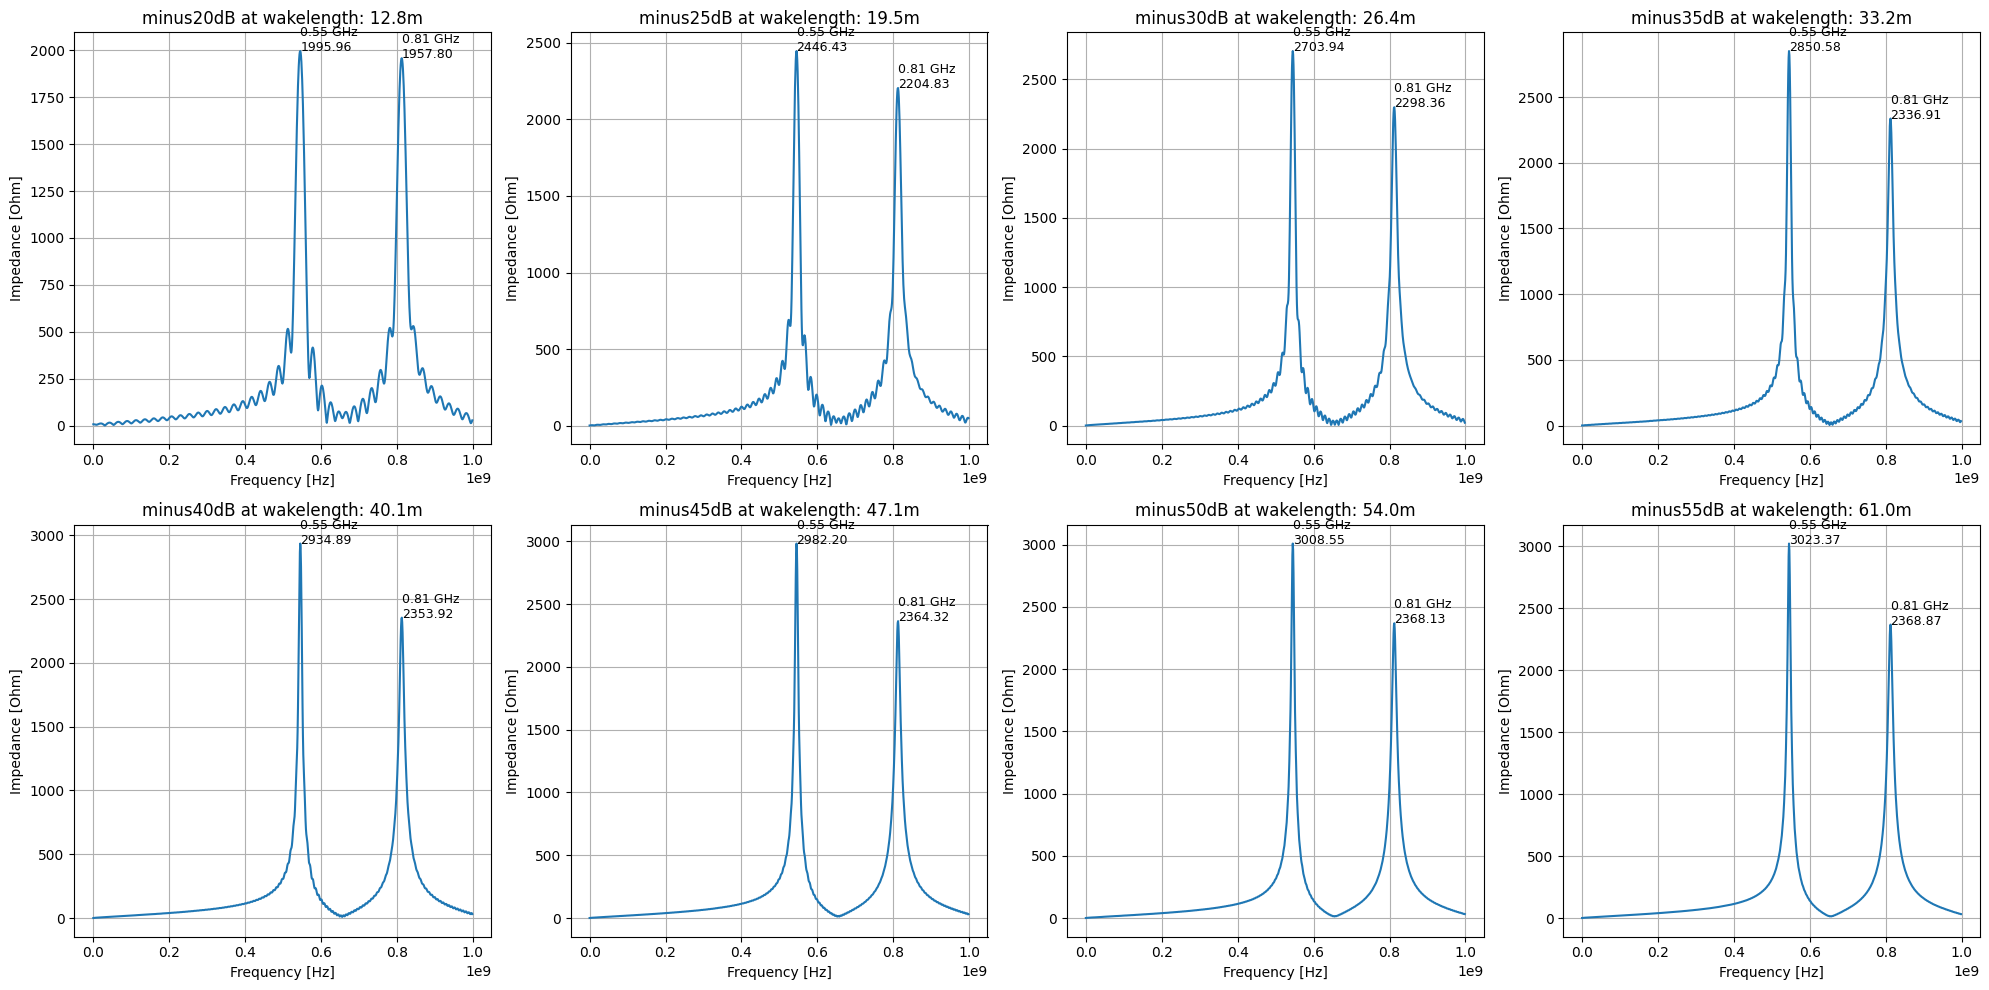

In [34]:
attenuations = [-20.0, -25.0, -30.0, -35.0, -40.0, -45.0, -50.0, -55.0]
row_indices = {}

for attenuation in attenuations:
    row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(data_wake, data_energy, attenuation)

impedances_attenuations = row_indices.copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(row_indices.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        wake = WakeSolver(q=1e-9, sigmaz=0.1)
        wake.WP = data_wake[:value, 1]
        wake.s = data_wake[:value, 0] / 100  # Converting from cm to m
        wake.calc_lambdas_analytic()
        wake.calc_long_Z(samples=1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=1e3, threshold=None)
        
        axes[row, col].plot(wake.f, np.abs(wake.Z))
        axes[row, col].set_title(f'{key} at wakelength: {data_wake[value, 0]/100:.1f}m')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e9:.2f} GHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        impedances_attenuations.update({key: wake.Z})


fig.tight_layout()
plt.show()


In [14]:
frequency = wake.f # Frequency in Hz

Nres = 2

bounds = [(4e3, 10e3), (1, 1e3), (0.3e9, 0.9e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [15]:
%%time
results = {}
for key, impedance in impedances_attenuations.items():
    GA_model_scipy = GeneticAlgorithm(frequency, 
                                      impedance, 
                                      time, 
                                      wake, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                     )
    GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                        popsize=150, 
                                        tol=0.001, 
                                        mutation=(0.1, 0.5), 
                                        crossover_rate=0.8
                                       )
    results[key] = GA_model_scipy
print(GA_model_scipy.warning)

Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        4.00e+03        |      86.34       |    5.453e+08     
    2     |        4.00e+03        |      116.01      |    8.122e+08     
----------------------------------------------------------------------
Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        4.00e+03        |      87.76       |    5.452e+08     
    2     |        4.00e+03        |      116.46      |    8.122e+08     
----------------------------------------------------------------------
Progress: [######################] 100% 



In [16]:
for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.18e+03        |      44.38       |    5.452e+08     
    2     |        2.18e+03        |      58.01       |    8.122e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.63e+03        |      56.84       |    5.453e+08     
    2     |        2.29e+03        |      61.49       |    8.122e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------

/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


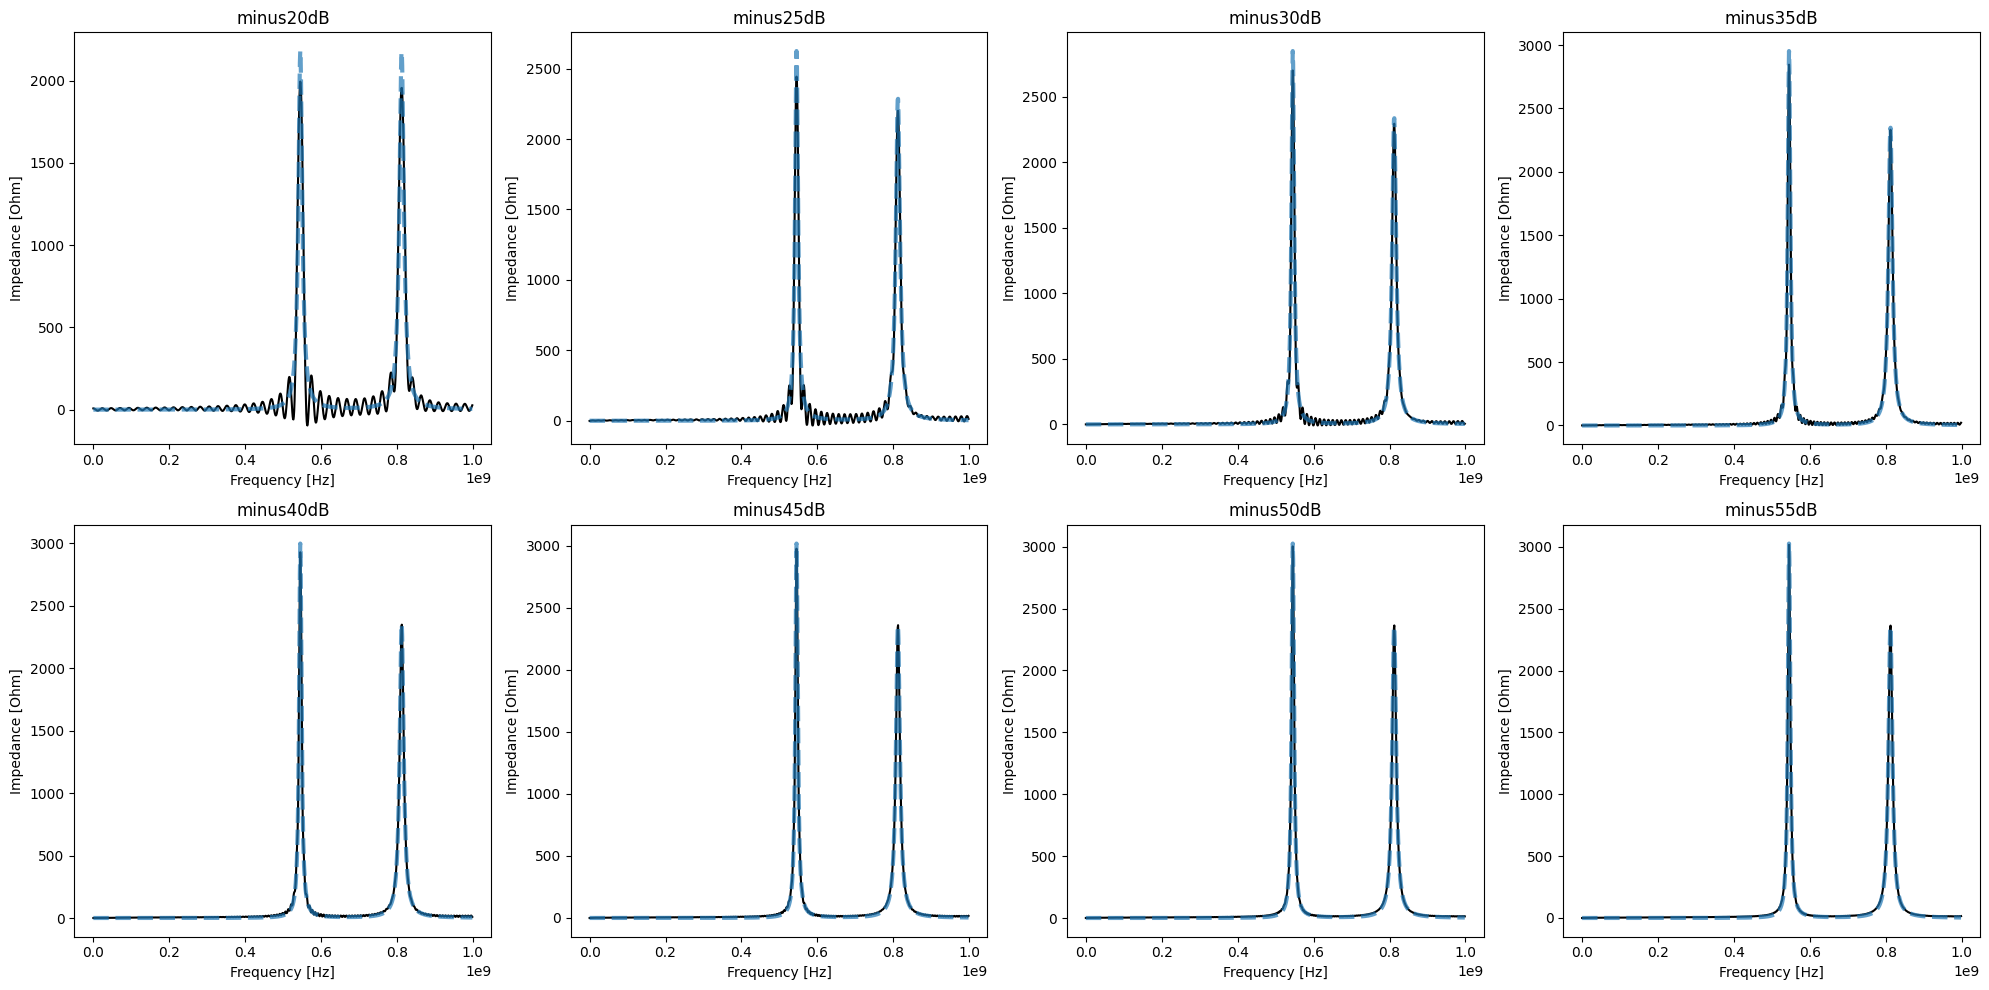

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        
        axes[row, col].plot(results[key].frequency_data, results[key].impedance_data, "black", label='CST data')
        axes[row, col].plot(results[key].frequency_data, results[key].fitFunction(results[key].frequency_data, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
fig.tight_layout()
plt.show()


In [18]:
# Extrapolating the wake until 210m wakelength

end_time = 210/c_light # Converting from wake length to time. 

"""The time of 210m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(list(results.values())[0].time_data[0], end_time, int(np.round(len(list(results.values())[0].time_data)*(end_time/(list(results.values())[0].time_data[-1])))))

In [19]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolations = {}

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
        wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
        wake_extrapolations[key] = wake_extrapolated

In [20]:
# Computing the impedance of the fully decayed simulated data:

#instantiating a class. An instance of the WakeSolver class.
wake_fully_simulated = WakeSolver(q = 1e-9, sigmaz = 0.1)

wake_fully_simulated.WP = data_wake[:,1]

wake_fully_simulated.s = data_wake[:,0]/100

#wake_fully_simulated.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

wake_fully_simulated.calc_lambdas_analytic()

wake_fully_simulated.calc_long_Z(samples=1001)

peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

Calculating longitudinal impedance Z...


Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


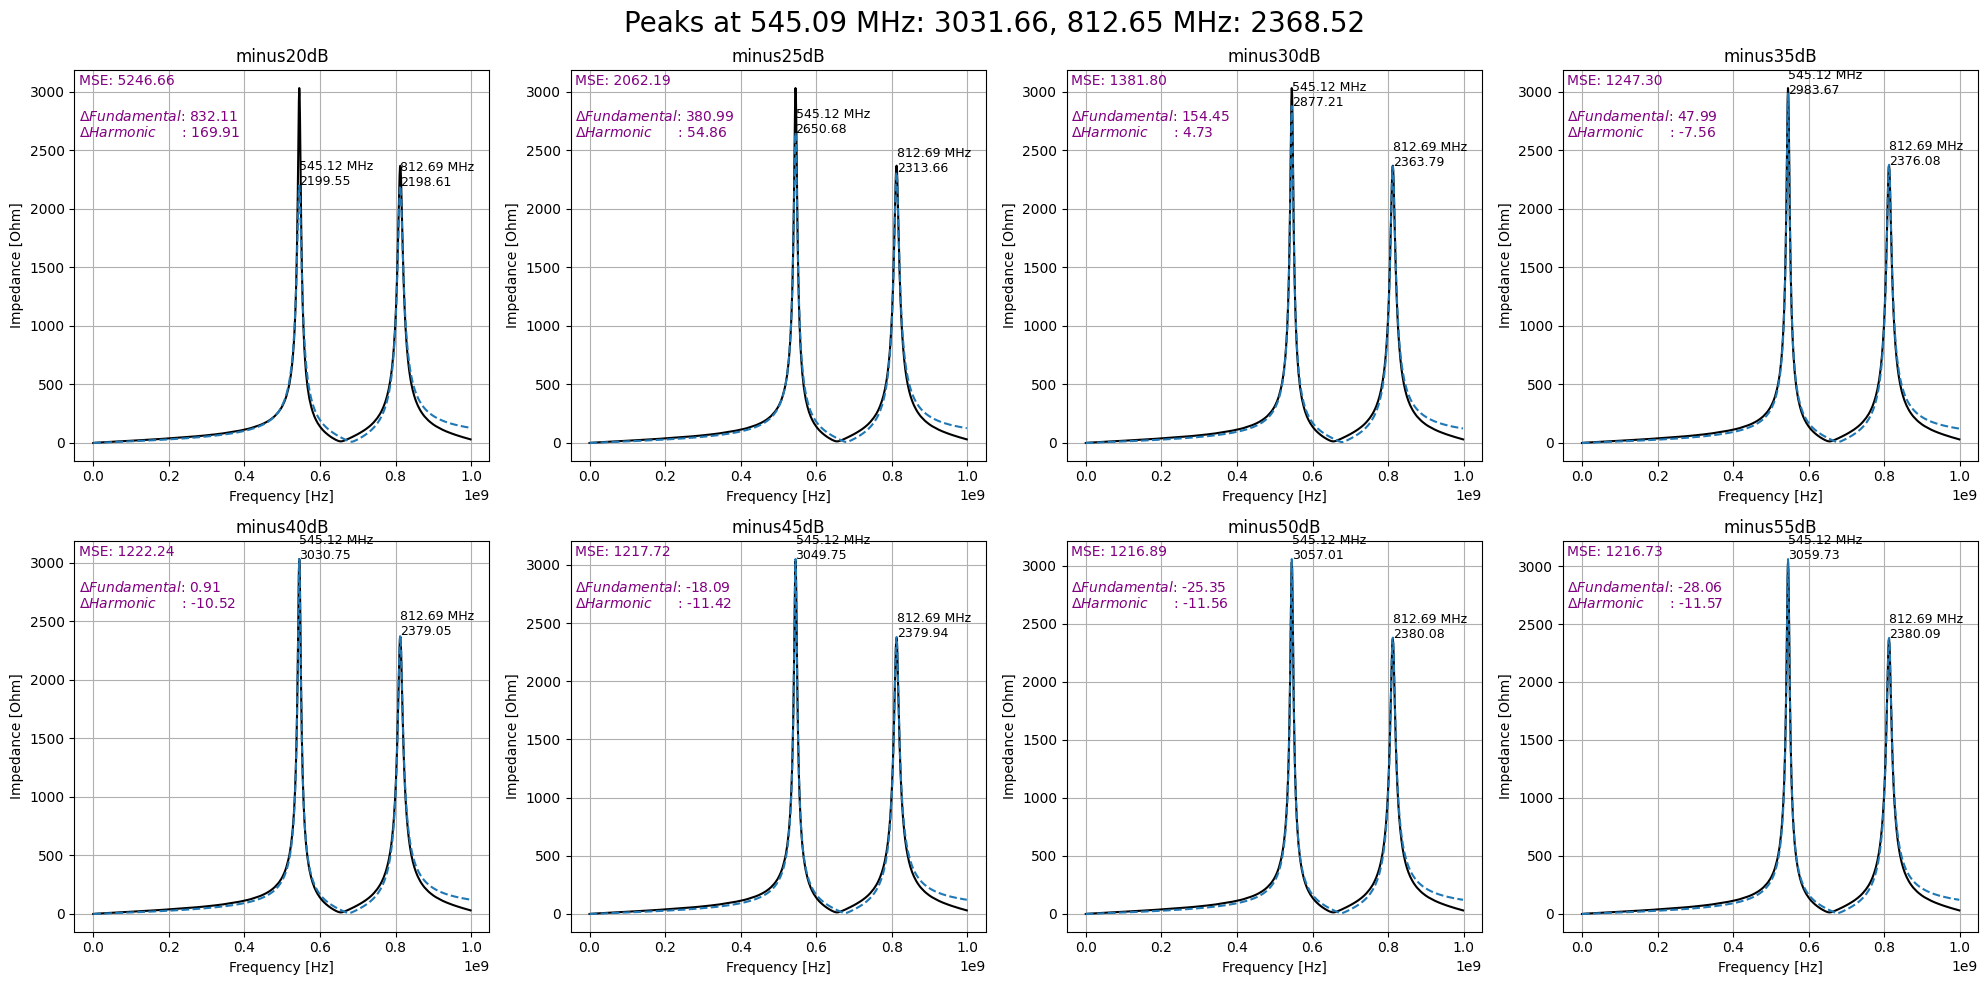

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
peak_info = ', '.join([f'{wake.f[peak]/1e6:.2f} MHz: {height:.2f}' for peak, height in zip(peaks_fs, peaks_height_fs['peak_heights'])])
st = fig.suptitle(f'Peaks at {peak_info}', fontsize=20)

impedance_results = {}

for idx, (key, value) in enumerate(wake_extrapolations.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        #instantiating a class. An instance of the WakeSolver class.
        wake = WakeSolver(q = 1e-9, sigmaz = 0.1)

        #setting the wake potential and time data

        wake.WP = value[:, 1]

        wake.s = new_time_extrapolate*c_light

        wake.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

        # Computing the impedance using the WakeSolver class and plotting the result

        wake.calc_long_Z(samples = 1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
        
        axes[row, col].plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z), color='black')
        axes[row, col].plot(wake.f, np.abs(wake.Z), linestyle='--')
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e6:.2f} MHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        mse = np.mean((np.abs(wake_fully_simulated.Z) - np.abs(wake.Z))**2)
        axes[row, col].text(.01, .99, f'MSE: {mse:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .90, f'$\Delta Fundamental$: {peaks_height_fs["peak_heights"][0] - peaks_height["peak_heights"][0]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .86, f'$\Delta Harmonic$      : {peaks_height_fs["peak_heights"][1] - peaks_height["peak_heights"][1]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)


fig.tight_layout()
plt.show()


### 1e3 CONDUCTIVITY

In [56]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e3p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e3energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


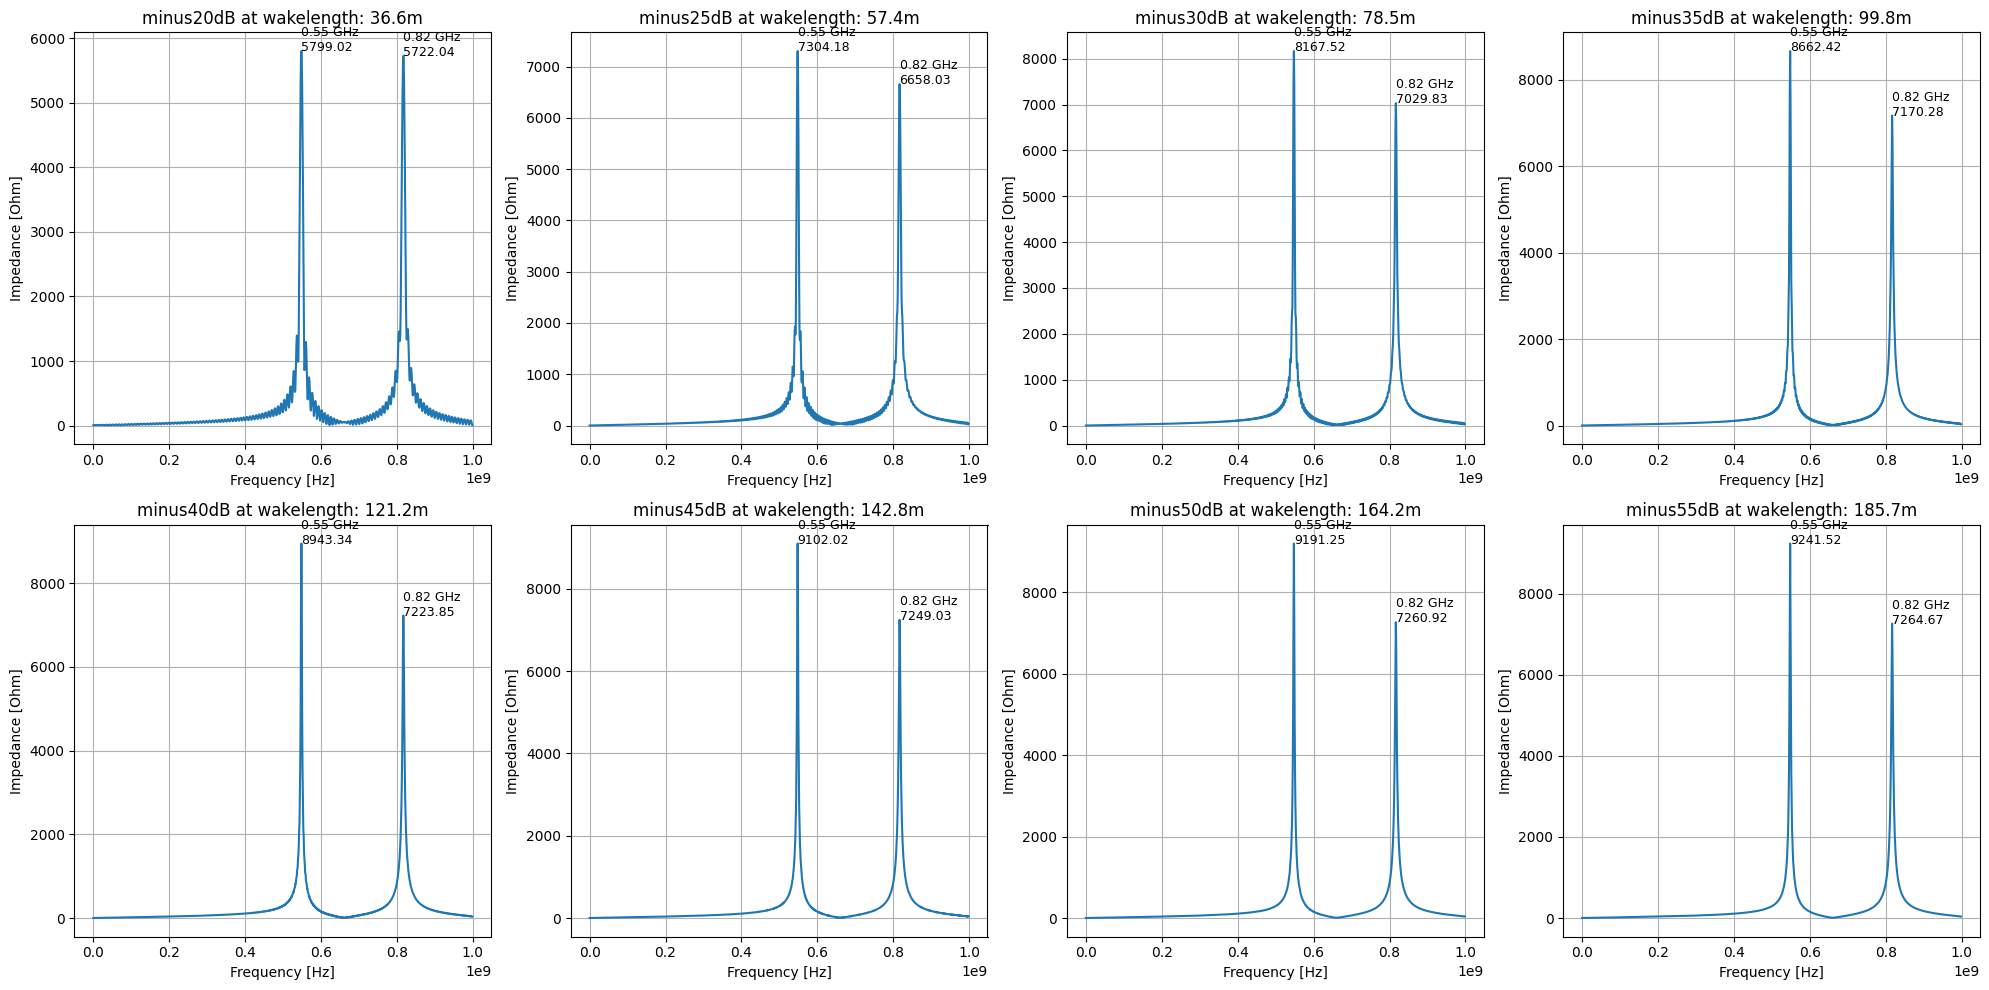

In [57]:
attenuations = [-20.0, -25.0, -30.0, -35.0, -40.0, -45.0, -50.0, -55.0]
row_indices = {}

for attenuation in attenuations:
    row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(data_wake, data_energy, attenuation)

impedances_attenuations = row_indices.copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(row_indices.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        wake = WakeSolver(q=1e-9, sigmaz=0.1)
        wake.WP = data_wake[:value, 1]
        wake.s = data_wake[:value, 0] / 100  # Converting from cm to m
        wake.calc_lambdas_analytic()
        wake.calc_long_Z(samples=1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
        
        axes[row, col].plot(wake.f, np.abs(wake.Z))
        axes[row, col].set_title(f'{key} at wakelength: {data_wake[value, 0]/100:.1f}m')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e9:.2f} GHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        impedances_attenuations.update({key: wake.Z})


fig.tight_layout()
plt.show()


In [58]:
frequency = wake.f # Frequency in Hz

Nres = 2

bounds = [(4e3, 10e3), (1, 1e3), (0.3e9, 0.9e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [59]:
%%time
results = {}
for key, impedance in impedances_attenuations.items():
    GA_model_scipy = GeneticAlgorithm(frequency, 
                                      impedance, 
                                      time, 
                                      wake, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                     )
    GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                        popsize=150, 
                                        tol=0.001, 
                                        mutation=(0.1, 0.5), 
                                        crossover_rate=0.8
                                       )
    results[key] = GA_model_scipy
print(GA_model_scipy.warning)

Progress: [#########################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.21e+03        |      157.77      |    8.167e+08     
    2     |        6.41e+03        |      128.22      |    5.481e+08     
----------------------------------------------------------------------
Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.01e+03        |      188.65      |    8.167e+08     
    2     |        7.93e+03        |      170.13      |    5.481e+08     
----------------------------------------------------------------------
Progress: [#####################] 100% 


In [60]:
for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.20e+03        |      157.11      |    8.167e+08     
    2     |        6.40e+03        |      128.09      |    5.481e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.99e+03        |      188.03      |    8.167e+08     
    2     |        7.93e+03        |      170.08      |    5.481e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------

/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


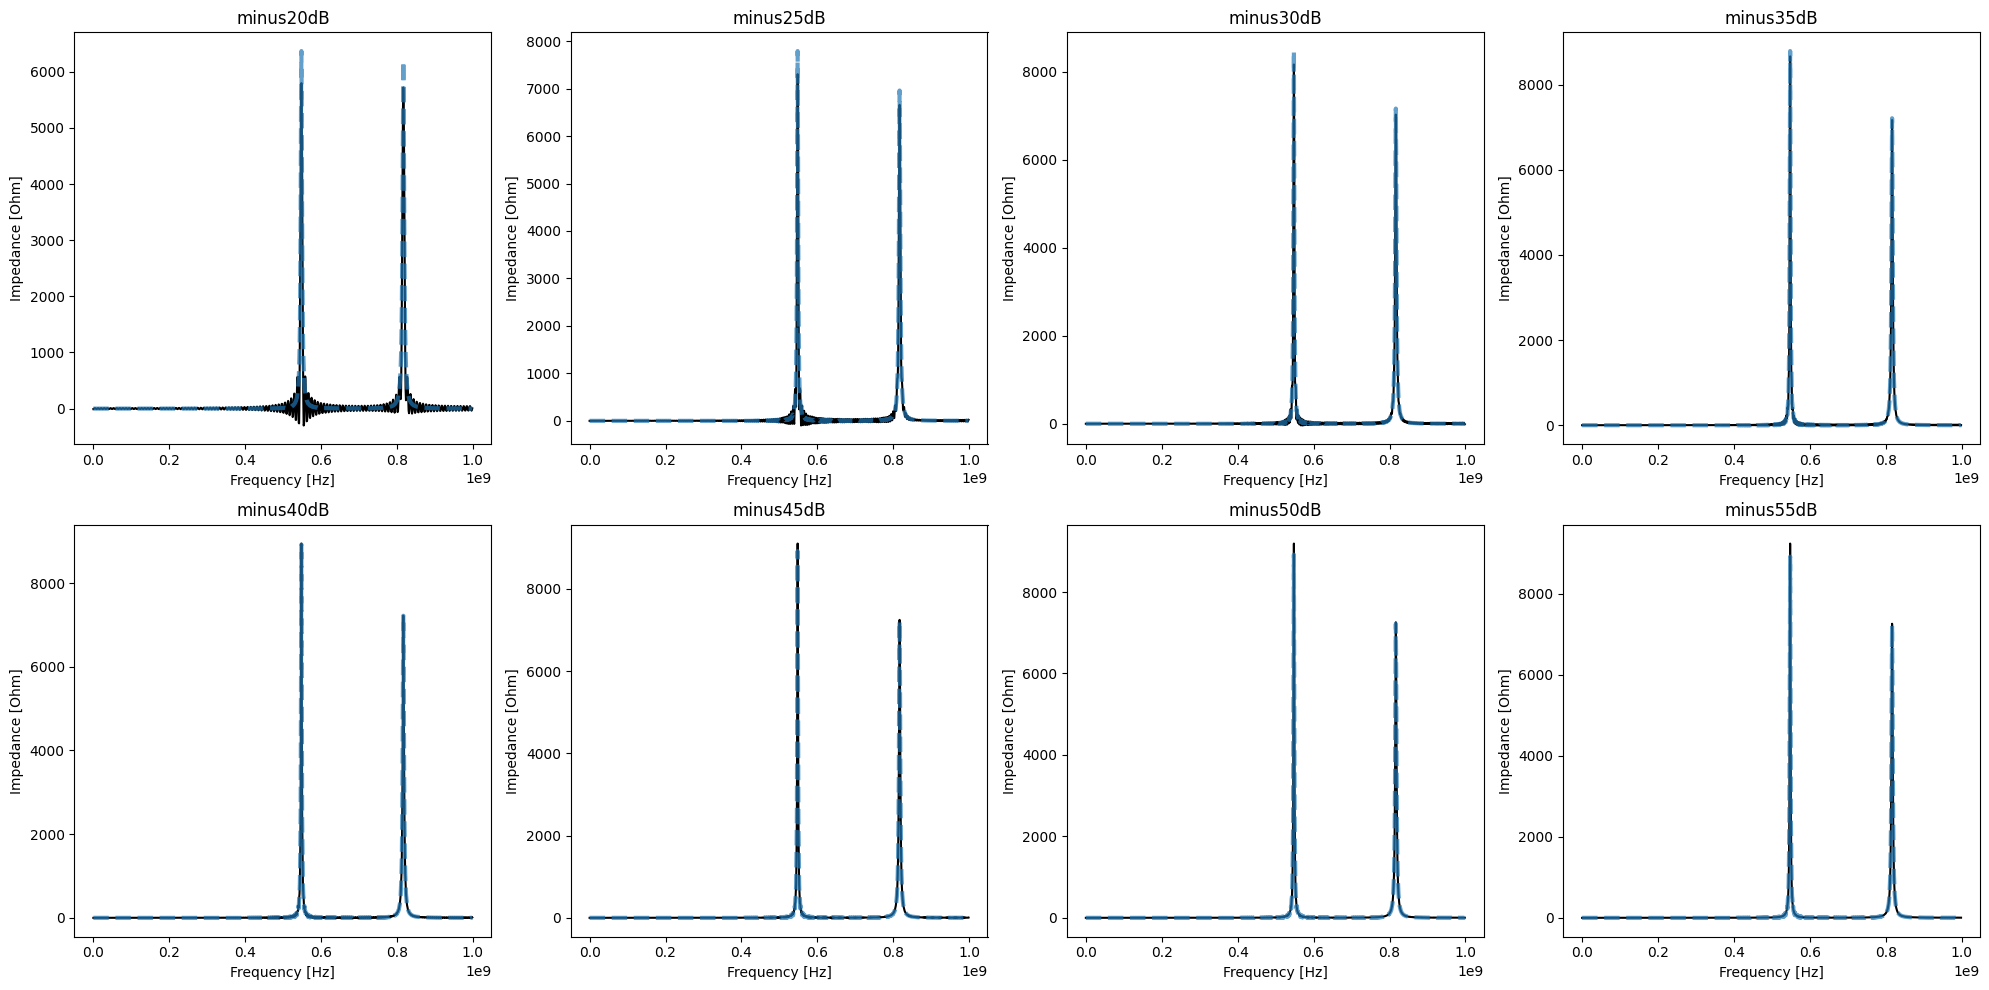

In [61]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        
        axes[row, col].plot(results[key].frequency_data, results[key].impedance_data, "black", label='CST data')
        axes[row, col].plot(results[key].frequency_data, results[key].fitFunction(results[key].frequency_data, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
fig.tight_layout()
plt.show()


In [62]:
# Extrapolating the wake until 210m wakelength

end_time = 210/c_light # Converting from wake length to time. 

"""The time of 210m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(results["minus20dB"].time_data[0], end_time, int(np.round(len(results["minus20dB"].time_data)*(end_time/(results["minus20dB"].time_data[-1])))))

In [63]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolations = {}

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
        wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
        wake_extrapolations[key] = wake_extrapolated

In [64]:
# Computing the impedance of the fully decayed simulated data:

#instantiating a class. An instance of the WakeSolver class.
wake_fully_simulated = WakeSolver(q = 1e-9, sigmaz = 0.1)

wake_fully_simulated.WP = data_wake[:,1]

wake_fully_simulated.s = data_wake[:,0]/100

#wake_fully_simulated.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

wake_fully_simulated.calc_lambdas_analytic()

wake_fully_simulated.calc_long_Z(samples=1001)

peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

Calculating longitudinal impedance Z...


Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


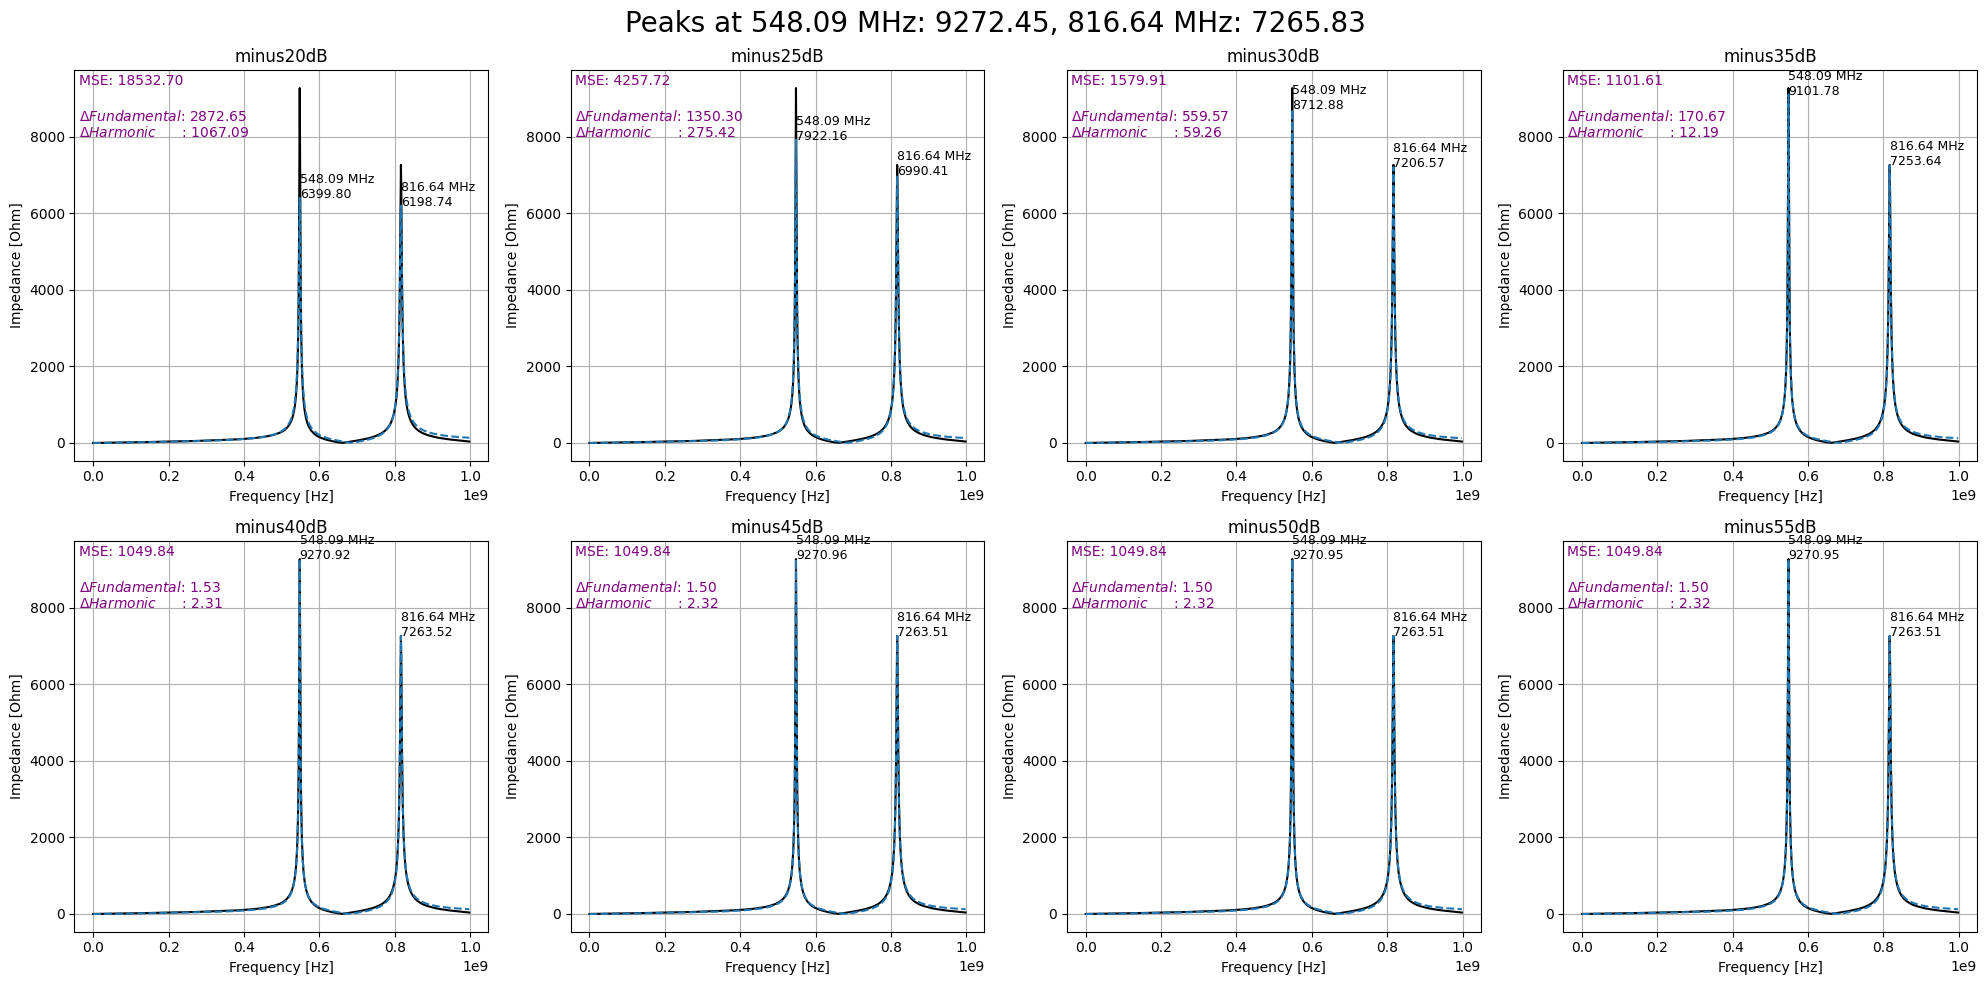

In [76]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
peak_info = ', '.join([f'{wake.f[peak]/1e6:.2f} MHz: {height:.2f}' for peak, height in zip(peaks_fs, peaks_height_fs['peak_heights'])])
st = fig.suptitle(f'Peaks at {peak_info}', fontsize=20)

impedance_results = {}

for idx, (key, value) in enumerate(wake_extrapolations.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        #instantiating a class. An instance of the WakeSolver class.
        wake = WakeSolver(q = 1e-9, sigmaz = 0.1)

        #setting the wake potential and time data

        wake.WP = value[:, 1]

        wake.s = new_time_extrapolate*c_light

        wake.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

        # Computing the impedance using the WakeSolver class and plotting the result

        wake.calc_long_Z(samples = 1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
        
        axes[row, col].plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z), color='black')
        axes[row, col].plot(wake.f, np.abs(wake.Z), linestyle='--')
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e6:.2f} MHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        mse = np.mean((np.abs(wake_fully_simulated.Z) - np.abs(wake.Z))**2)
        axes[row, col].text(.01, .99, f'MSE: {mse:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .90, f'$\Delta Fundamental$: {peaks_height_fs["peak_heights"][0] - peaks_height["peak_heights"][0]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .86, f'$\Delta Harmonic$      : {peaks_height_fs["peak_heights"][1] - peaks_height["peak_heights"][1]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)


fig.tight_layout()
plt.show()


### 1e3 COND. Continued

In [77]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e3p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e3energy.txt', comments='#', delimiter='\t')

In [78]:
attenuations = np.linspace(-31, -40, 10)
print(attenuations)
row_indices = {}

for attenuation in attenuations:
    row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(data_wake, data_energy, attenuation)

impedances_attenuations = row_indices.copy()

for idx, (key, value) in enumerate(row_indices.items()):
    if key != 'key':  # Skip the 'key' entry
        wake = WakeSolver(q=1e-9, sigmaz=0.1)
        wake.WP = data_wake[:value, 1]
        wake.s = data_wake[:value, 0] / 100  # Converting from cm to m
        wake.calc_lambdas_analytic()
        wake.calc_long_Z(samples=1001)

        impedances_attenuations.update({key: wake.Z})


[-31. -32. -33. -34. -35. -36. -37. -38. -39. -40.]
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


In [79]:
frequency = wake.f # Frequency in Hz

Nres = 2

bounds = [(4e3, 10e3), (1, 1e3), (0.3e9, 0.9e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [80]:
%%time
results = {}
for key, impedance in impedances_attenuations.items():
    GA_model_scipy = GeneticAlgorithm(frequency, 
                                      impedance, 
                                      time, 
                                      wake, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                     )
    GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                        popsize=150, 
                                        tol=0.001, 
                                        mutation=(0.1, 0.5), 
                                        crossover_rate=0.8
                                       )
    results[key] = GA_model_scipy
print(GA_model_scipy.warning)

Progress: [######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.22e+03        |      198.22      |    8.167e+08     
    2     |        8.84e+03        |      199.42      |    5.481e+08     
----------------------------------------------------------------------
Progress: [#####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        8.94e+03        |      203.00      |    5.481e+08     
    2     |        7.23e+03        |      199.05      |    8.167e+08     
----------------------------------------------------------------------
Progress: [#####################] 100% 


---

In [81]:
for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.23e+03        |      198.47      |    8.167e+08     
    2     |        8.84e+03        |      199.50      |    5.481e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        8.93e+03        |      202.74      |    5.481e+08     
    2     |        7.23e+03        |      198.93      |    8.167e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


------------------------------------------------

In [82]:
# Extrapolating the wake until 210m wakelength

end_time = 210/c_light # Converting from wake length to time. 

"""The time of 210m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(list(results.values())[0].time_data[0], end_time, int(np.round(len(list(results.values())[0].time_data)*(end_time/(list(results.values())[0].time_data[-1])))))

In [83]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolations = {}

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
        wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
        wake_extrapolations[key] = wake_extrapolated

In [84]:
# Computing the impedance of the fully decayed simulated data:

#instantiating a class. An instance of the WakeSolver class.
wake_fully_simulated = WakeSolver(q = 1e-9, sigmaz = 0.1)

wake_fully_simulated.WP = data_wake[:,1]

wake_fully_simulated.s = data_wake[:,0]/100

#wake_fully_simulated.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

wake_fully_simulated.calc_lambdas_analytic()

wake_fully_simulated.calc_long_Z(samples=1001)

peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

Calculating longitudinal impedance Z...


Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


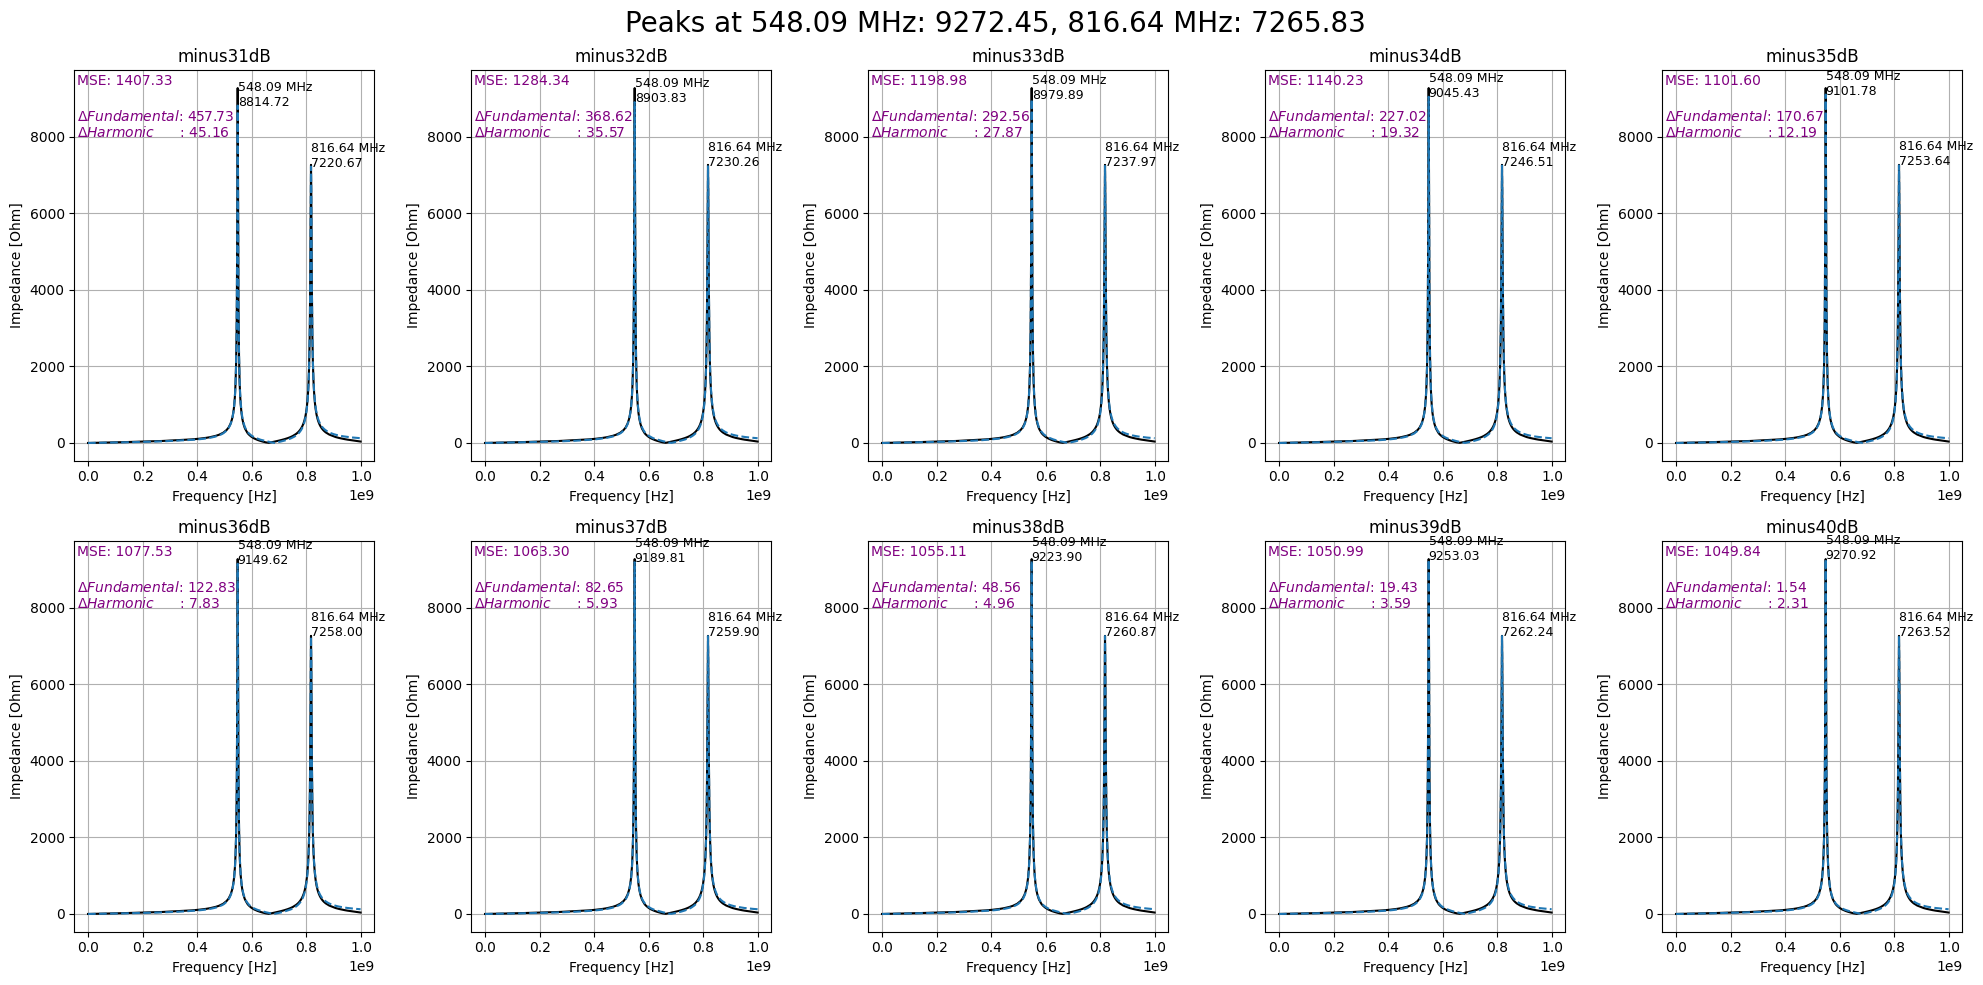

In [85]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
peak_info = ', '.join([f'{wake.f[peak]/1e6:.2f} MHz: {height:.2f}' for peak, height in zip(peaks_fs, peaks_height_fs['peak_heights'])])
st = fig.suptitle(f'Peaks at {peak_info}', fontsize=20)

impedance_results = {}

for idx, (key, value) in enumerate(wake_extrapolations.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 5
        col = idx % 5
        #instantiating a class. An instance of the WakeSolver class.
        wake = WakeSolver(q = 1e-9, sigmaz = 0.1)

        #setting the wake potential and time data

        wake.WP = value[:, 1]

        wake.s = new_time_extrapolate*c_light

        wake.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

        # Computing the impedance using the WakeSolver class and plotting the result

        wake.calc_long_Z(samples = 1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
        
        axes[row, col].plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z), color='black')
        axes[row, col].plot(wake.f, np.abs(wake.Z), linestyle='--')
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e6:.2f} MHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        mse = np.mean((np.abs(wake_fully_simulated.Z) - np.abs(wake.Z))**2)
        axes[row, col].text(.01, .99, f'MSE: {mse:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .90, f'$\Delta Fundamental$: {peaks_height_fs["peak_heights"][0] - peaks_height["peak_heights"][0]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .86, f'$\Delta Harmonic$      : {peaks_height_fs["peak_heights"][1] - peaks_height["peak_heights"][1]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)


fig.tight_layout()
plt.show()


### 1e4 CONDUCTIVITY

In [99]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e4p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e4energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


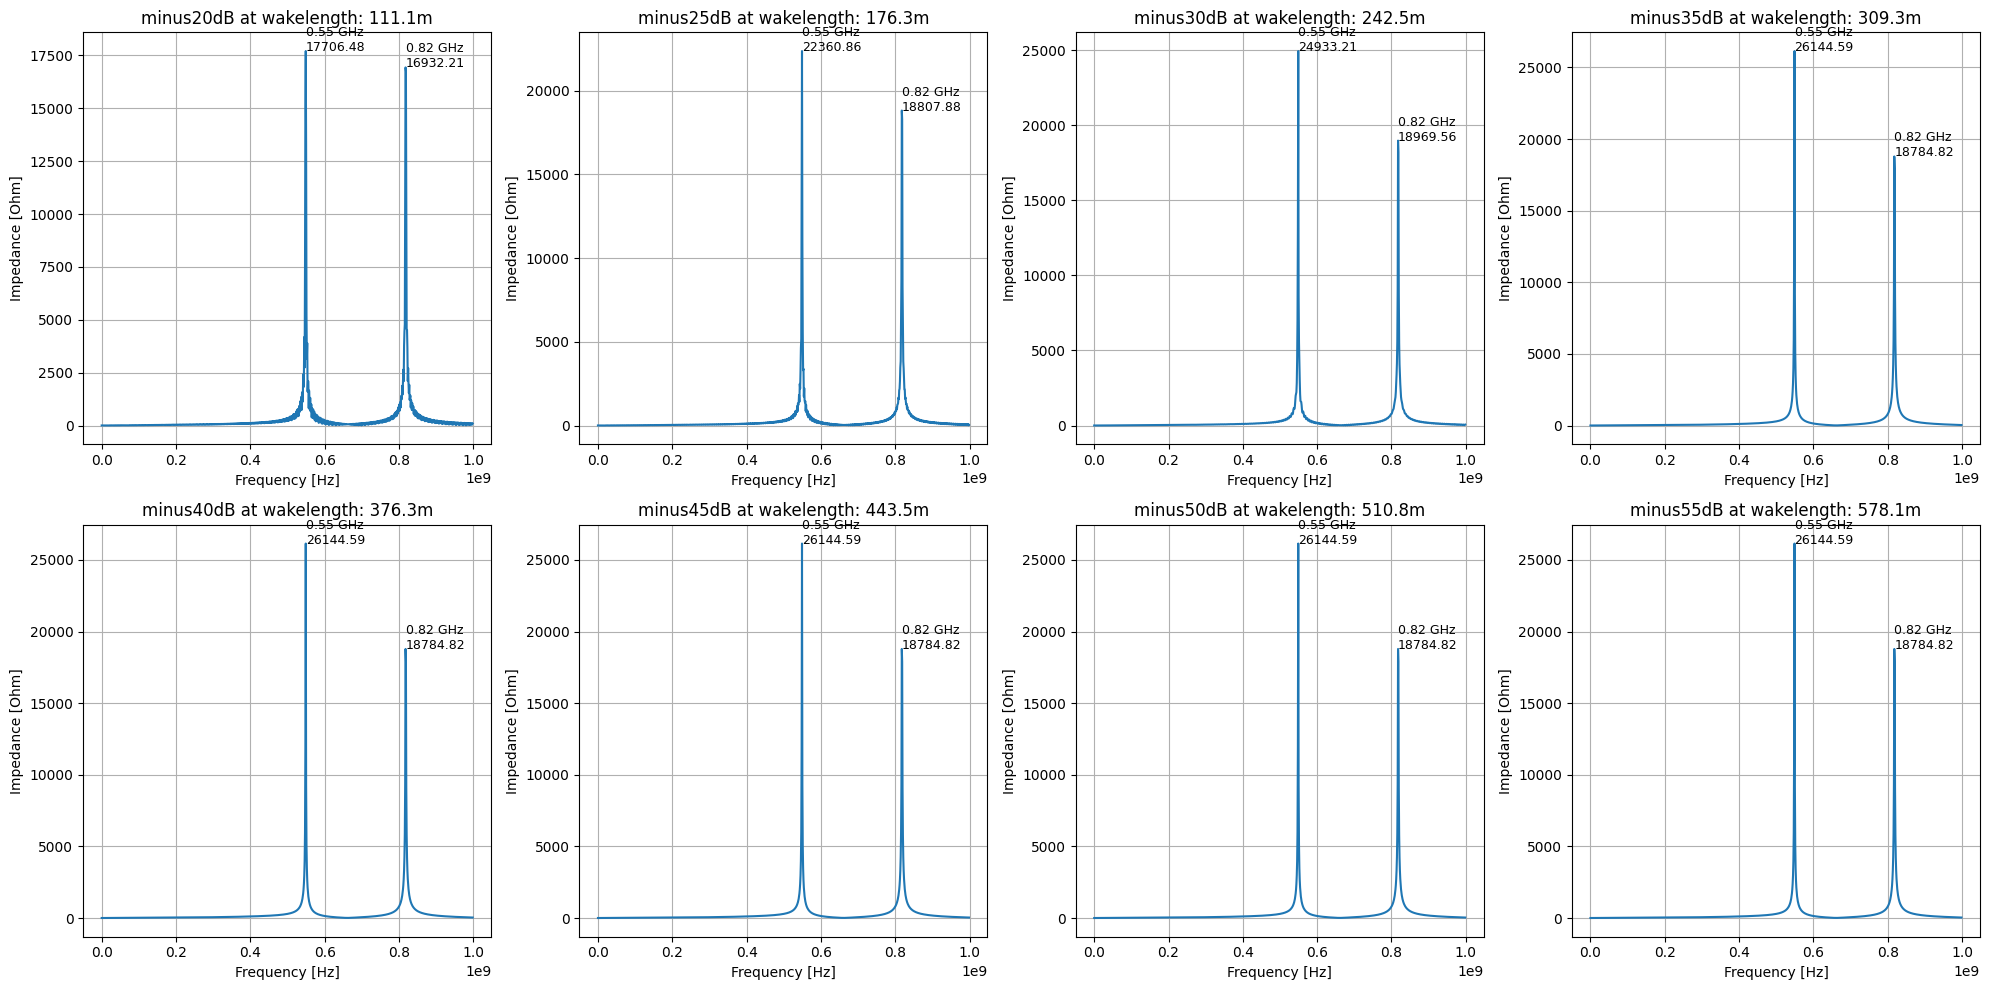

In [100]:
attenuations = [-20.0, -25.0, -30.0, -35.0, -40.0, -45.0, -50.0, -55.0]
row_indices = {}

for attenuation in attenuations:
    row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(data_wake, data_energy, attenuation)

impedances_attenuations = row_indices.copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(row_indices.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        wake = WakeSolver(q=1e-9, sigmaz=0.1)
        wake.WP = data_wake[:value, 1]
        wake.s = data_wake[:value, 0] / 100  # Converting from cm to m
        wake.calc_lambdas_analytic()
        wake.calc_long_Z(samples=1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=5e3, threshold=None)
        
        axes[row, col].plot(wake.f, np.abs(wake.Z))
        axes[row, col].set_title(f'{key} at wakelength: {data_wake[value, 0]/100:.1f}m')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e9:.2f} GHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        impedances_attenuations.update({key: wake.Z})


fig.tight_layout()
plt.show()


In [101]:
frequency = wake.f # Frequency in Hz

Nres = 2

bounds = [(10e3, 35e3), (1, 1e3), (0.3e9, 0.9e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [102]:
%%time
results = {}
for key, impedance in impedances_attenuations.items():
    GA_model_scipy = GeneticAlgorithm(frequency, 
                                      impedance, 
                                      time, 
                                      wake, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                     )
    GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                        popsize=150, 
                                        tol=0.001, 
                                        mutation=(0.1, 0.5), 
                                        crossover_rate=0.8
                                       )
    results[key] = GA_model_scipy
print(GA_model_scipy.warning)

Progress: [######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.14e+04        |      576.29      |    8.181e+08     
    2     |        2.52e+04        |      559.52      |    5.489e+08     
----------------------------------------------------------------------
Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.27e+04        |      628.82      |    8.181e+08     
    2     |        2.93e+04        |      684.79      |    5.489e+08     
----------------------------------------------------------------------
Progress: [#########################] 100% 

In [103]:
for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.14e+04        |      576.88      |    8.181e+08     
    2     |        2.52e+04        |      561.40      |    5.489e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.28e+04        |      629.36      |    8.181e+08     
    2     |        2.91e+04        |      678.48      |    5.489e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


------------------------------------------------

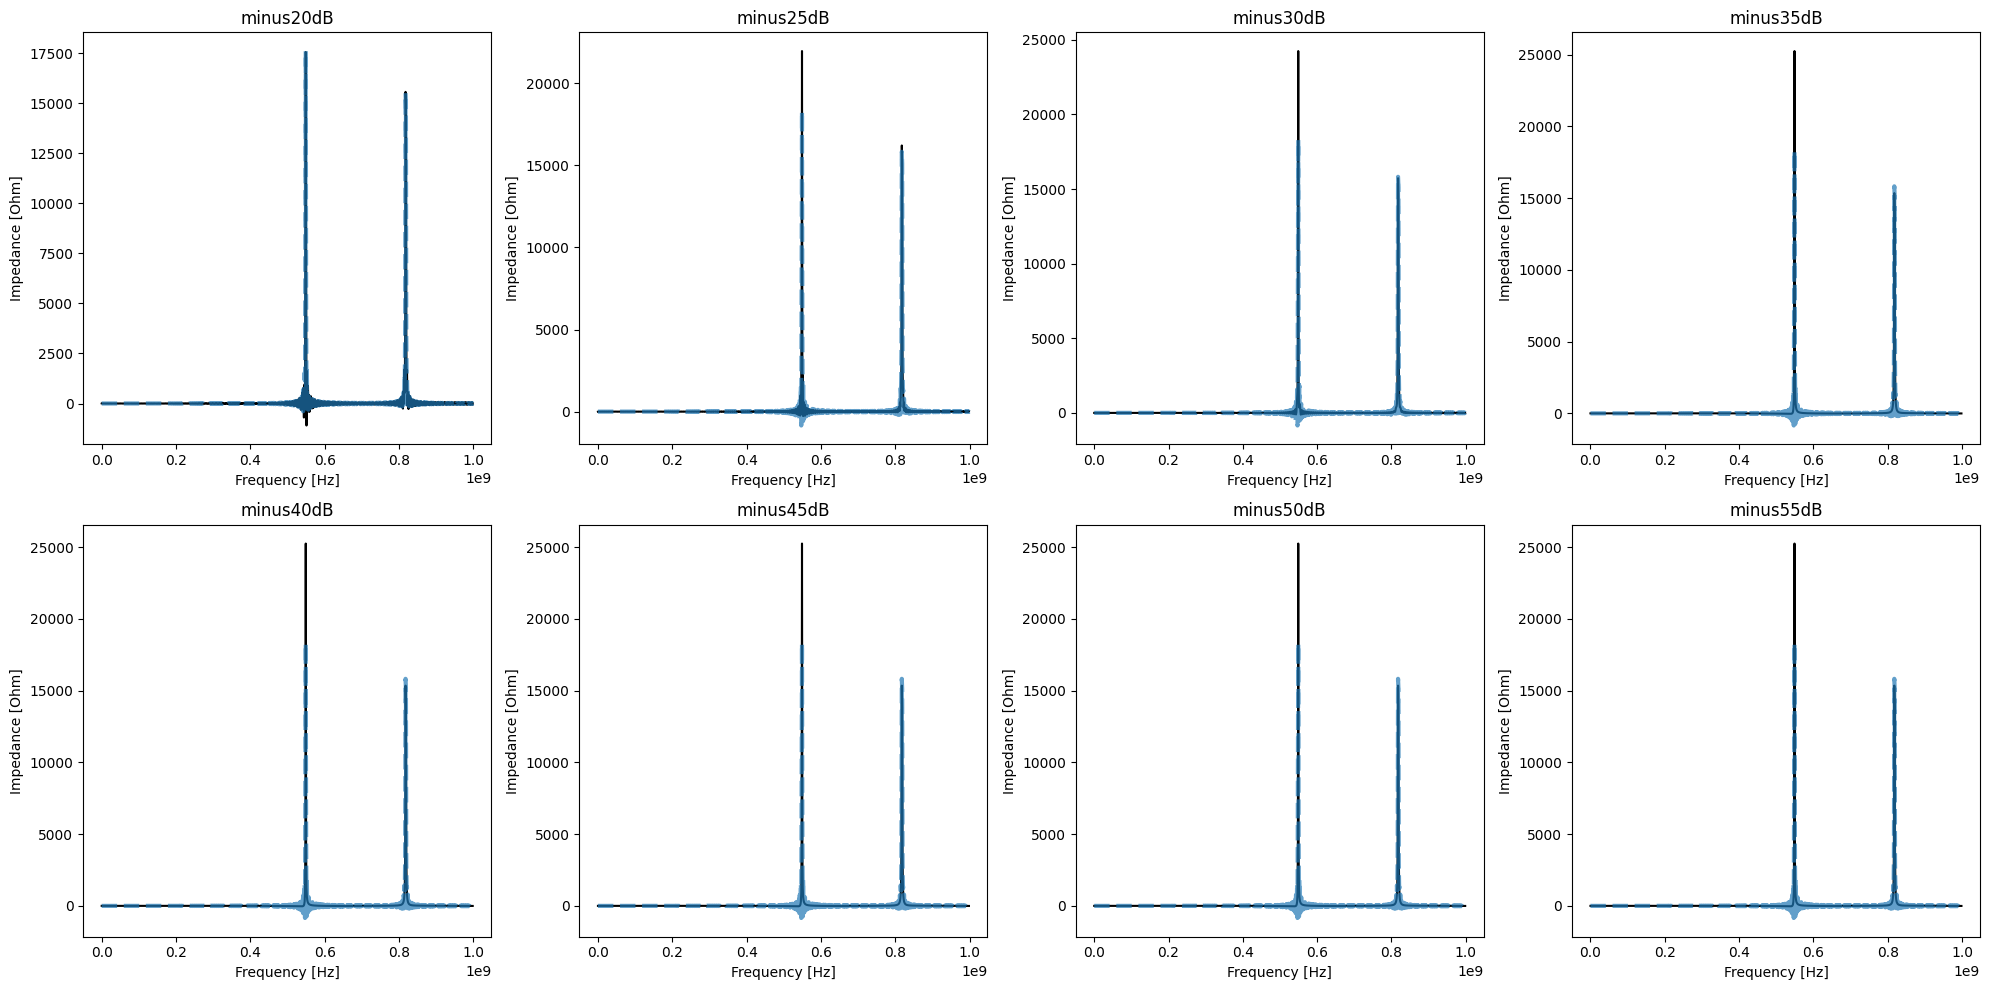

In [109]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        
        axes[row, col].plot(results[key].frequency_data, results[key].impedance_data, "black", label='CST data')
        axes[row, col].plot(results[key].frequency_data, results[key].fitFunction(results[key].frequency_data, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
fig.tight_layout()
plt.show()


In [110]:
# Extrapolating the wake until 625m wakelength

end_time = 650/c_light # Converting from wake length to time. 

"""The time of 625m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(results["minus20dB"].time_data[0], end_time, int(np.round(len(results["minus20dB"].time_data)*(end_time/(results["minus20dB"].time_data[-1])))))

In [111]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolations = {}

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
        wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
        wake_extrapolations[key] = wake_extrapolated

In [112]:
# Computing the impedance of the fully decayed simulated data:

#instantiating a class. An instance of the WakeSolver class.
wake_fully_simulated = WakeSolver(q = 1e-9, sigmaz = 0.1)

wake_fully_simulated.WP = data_wake[:,1]

wake_fully_simulated.s = data_wake[:,0]/100

wake_fully_simulated.calc_lambdas_analytic()

wake_fully_simulated.calc_long_Z(samples=1001)

peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

Calculating longitudinal impedance Z...


Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


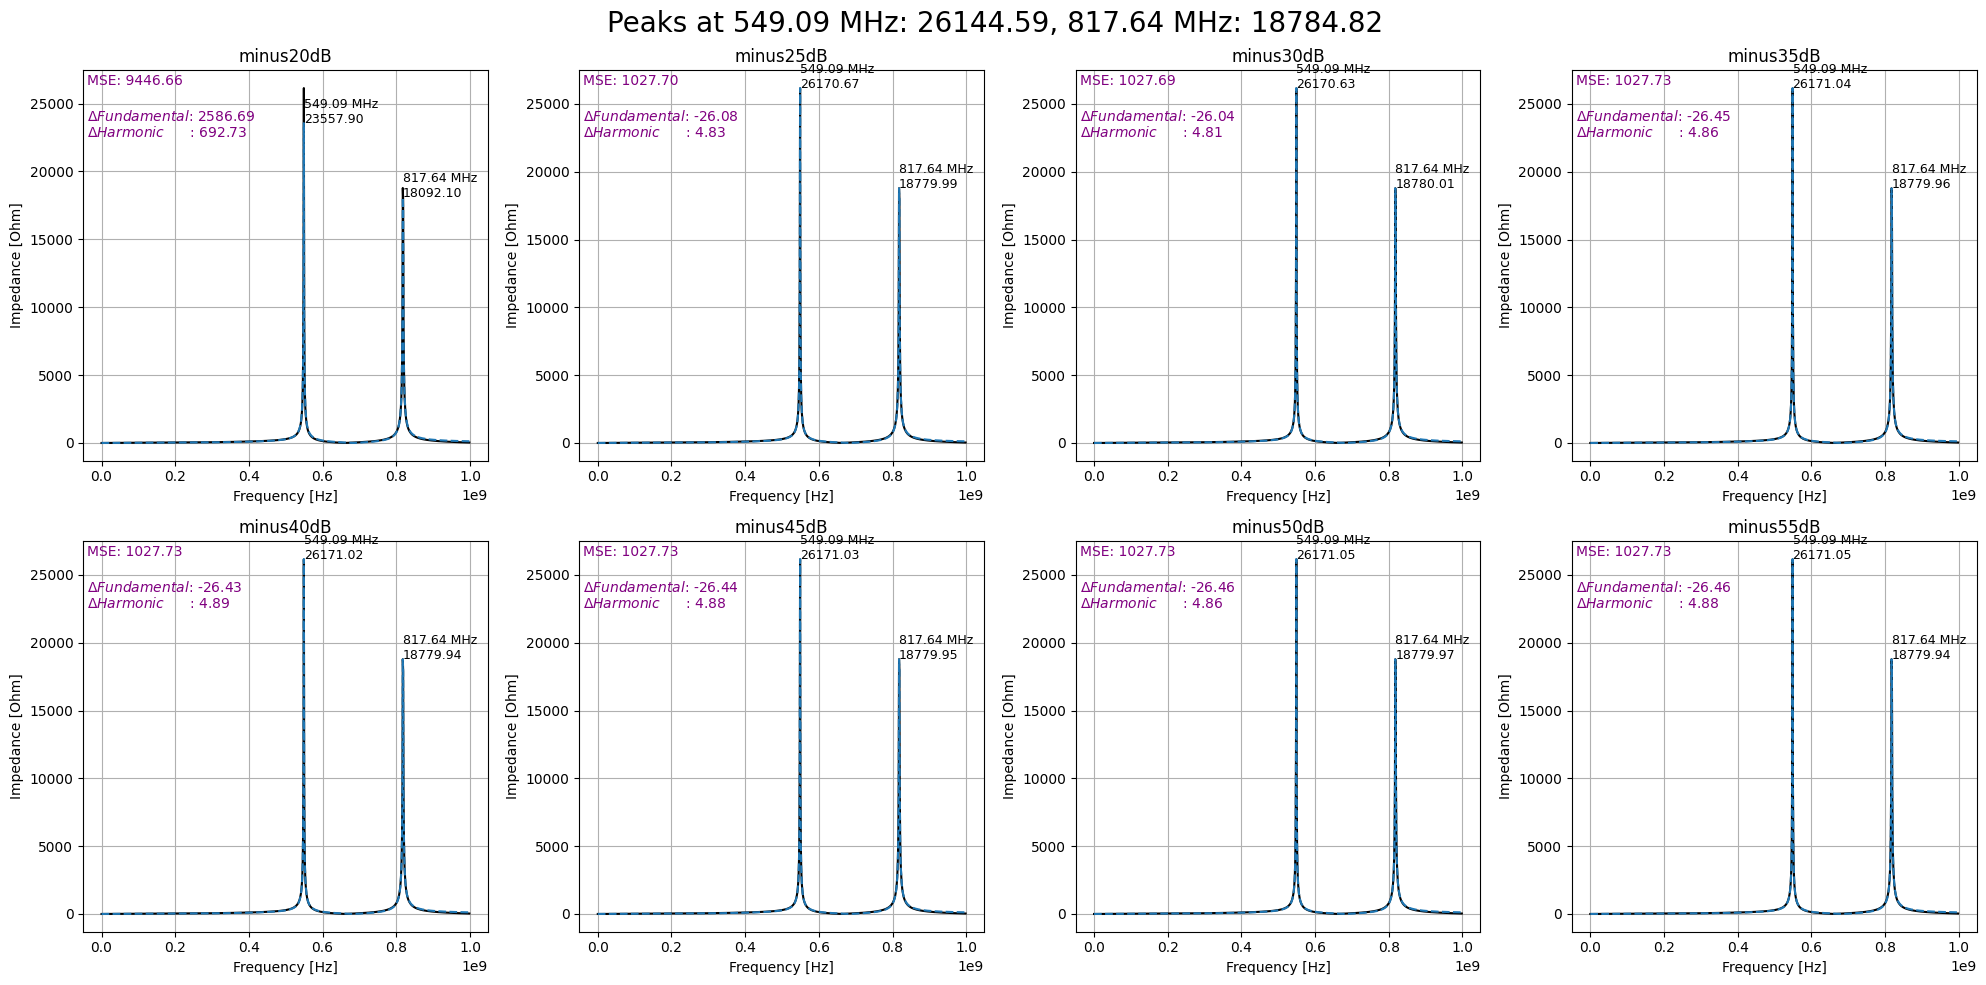

In [118]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
peak_info = ', '.join([f'{wake.f[peak]/1e6:.2f} MHz: {height:.2f}' for peak, height in zip(peaks_fs, peaks_height_fs['peak_heights'])])
st = fig.suptitle(f'Peaks at {peak_info}', fontsize=20)

impedance_results = {}

for idx, (key, value) in enumerate(wake_extrapolations.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        #instantiating a class. An instance of the WakeSolver class.
        wake = WakeSolver(q = 1e-9, sigmaz = 0.1)

        #setting the wake potential and time data

        wake.WP = value[:, 1]

        wake.s = new_time_extrapolate*c_light

        wake.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

        # Computing the impedance using the WakeSolver class and plotting the result

        wake.calc_long_Z(samples = 1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
        
        axes[row, col].plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z), color='black')
        axes[row, col].plot(wake.f, np.abs(wake.Z), linestyle='--')
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e6:.2f} MHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        mse = np.mean((np.abs(wake_fully_simulated.Z) - np.abs(wake.Z))**2)
        axes[row, col].text(.01, .99, f'MSE: {mse:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .90, f'$\Delta Fundamental$: {peaks_height_fs["peak_heights"][0] - peaks_height["peak_heights"][0]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .86, f'$\Delta Harmonic$      : {peaks_height_fs["peak_heights"][1] - peaks_height["peak_heights"][1]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)


fig.tight_layout()
plt.show()


### COND 1e5

In [74]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e5p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e5energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

In [75]:
attenuations = [-15.0, -25.0, -30.0, -35.0, -40.0, -45.0, -50.0, -55.0]
row_indices = {}

for attenuation in attenuations:
    row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(data_wake, data_energy, attenuation)

In [72]:
wake = WakeSolver(q=1e-9, sigmaz=0.1)
wake.WP = data_wake[:row_indices["minus35dB"],1]
wake.s = data_wake[:row_indices["minus35dB"],0] / 100  # Converting from cm to m
wake.calc_lambdas_analytic()
wake.calc_long_Z(samples=600)

Calculating longitudinal impedance Z...


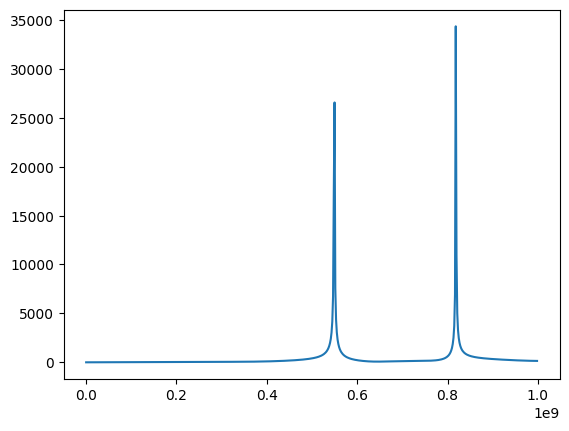

In [73]:
plt.plot(wake.f, np.abs(wake.Z))

minus15dB 206851
Calculating longitudinal impedance Z...
minus25dB 652153
Calculating longitudinal impedance Z...
minus30dB 881239
Calculating longitudinal impedance Z...
minus35dB 1111573
Calculating longitudinal impedance Z...
minus40dB 1342921
Calculating longitudinal impedance Z...
minus45dB 1574581
Calculating longitudinal impedance Z...
minus50dB 1806241
Calculating longitudinal impedance Z...
minus55dB 2038213
Calculating longitudinal impedance Z...


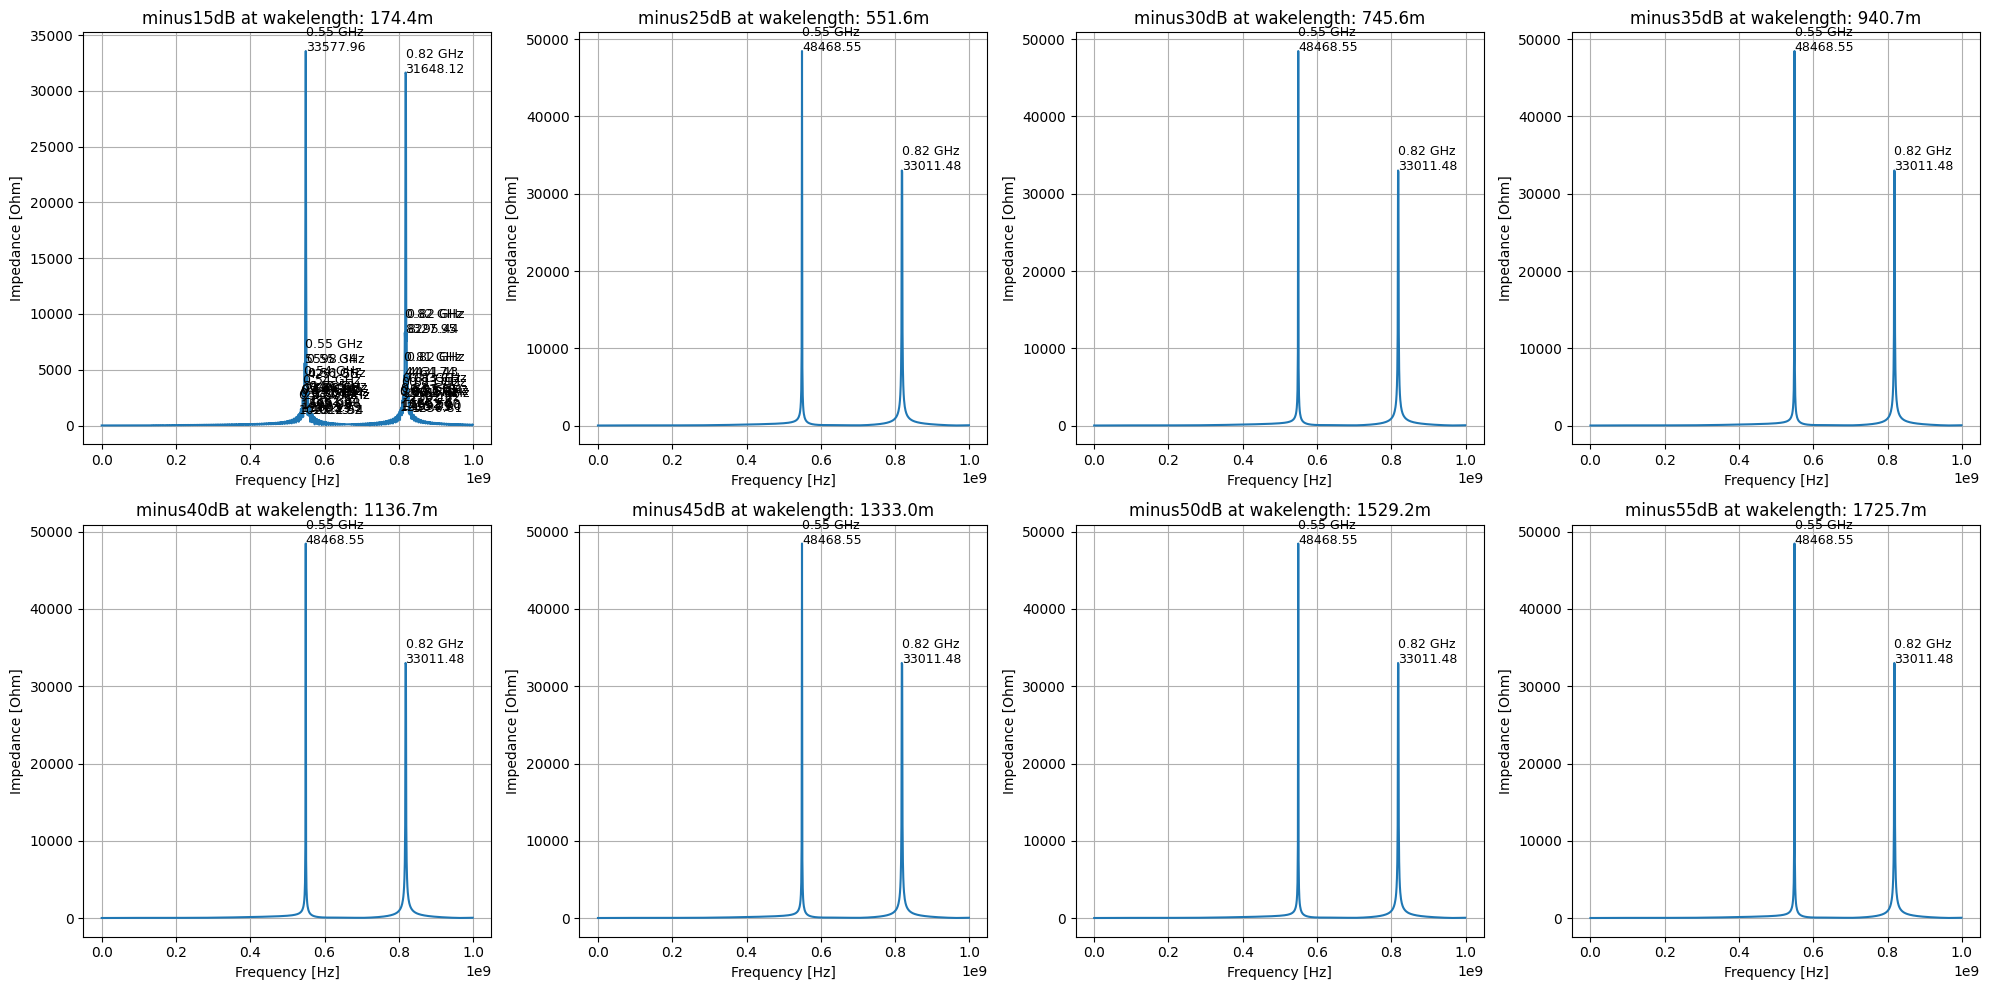

In [78]:
impedances_attenuations = row_indices.copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(row_indices.items()):
    if key != 'key':  # Skip the 'key' entry
        print(key, value)
        row = idx // 4
        col = idx % 4
        wake = WakeSolver(q=1e-9, sigmaz=0.1)
        wake.WP = data_wake[:value, 1]
        wake.s = data_wake[:value, 0] / 100  # Converting from cm to m
        wake.calc_lambdas_analytic()
        wake.calc_long_Z(samples=1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=1e3, threshold=None)
        
        axes[row, col].plot(wake.f, np.abs(wake.Z))
        axes[row, col].set_title(f'{key} at wakelength: {data_wake[value, 0]/100:.1f}m')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e9:.2f} GHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        impedances_attenuations.update({key: wake.Z})


fig.tight_layout()
plt.show()


In [ ]:
frequency = wake.f # Frequency in Hz

Nres = 2

bounds = [(4e3, 10e3), (1, 1e3), (0.3e9, 0.9e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [ ]:
%%time
results = {}
for key, impedance in impedances_attenuations.items():
    GA_model_scipy = GeneticAlgorithm(frequency, 
                                      impedance, 
                                      time, 
                                      wake, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                     )
    GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                        popsize=150, 
                                        tol=0.001, 
                                        mutation=(0.1, 0.5), 
                                        crossover_rate=0.8
                                       )
    results[key] = GA_model_scipy
print(GA_model_scipy.warning)

Progress: [#########################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.21e+03        |      157.77      |    8.167e+08     
    2     |        6.41e+03        |      128.22      |    5.481e+08     
----------------------------------------------------------------------
Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.01e+03        |      188.65      |    8.167e+08     
    2     |        7.93e+03        |      170.13      |    5.481e+08     
----------------------------------------------------------------------
Progress: [#####################] 100% 


In [ ]:
for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.20e+03        |      157.11      |    8.167e+08     
    2     |        6.40e+03        |      128.09      |    5.481e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.99e+03        |      188.03      |    8.167e+08     
    2     |        7.93e+03        |      170.08      |    5.481e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------

/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


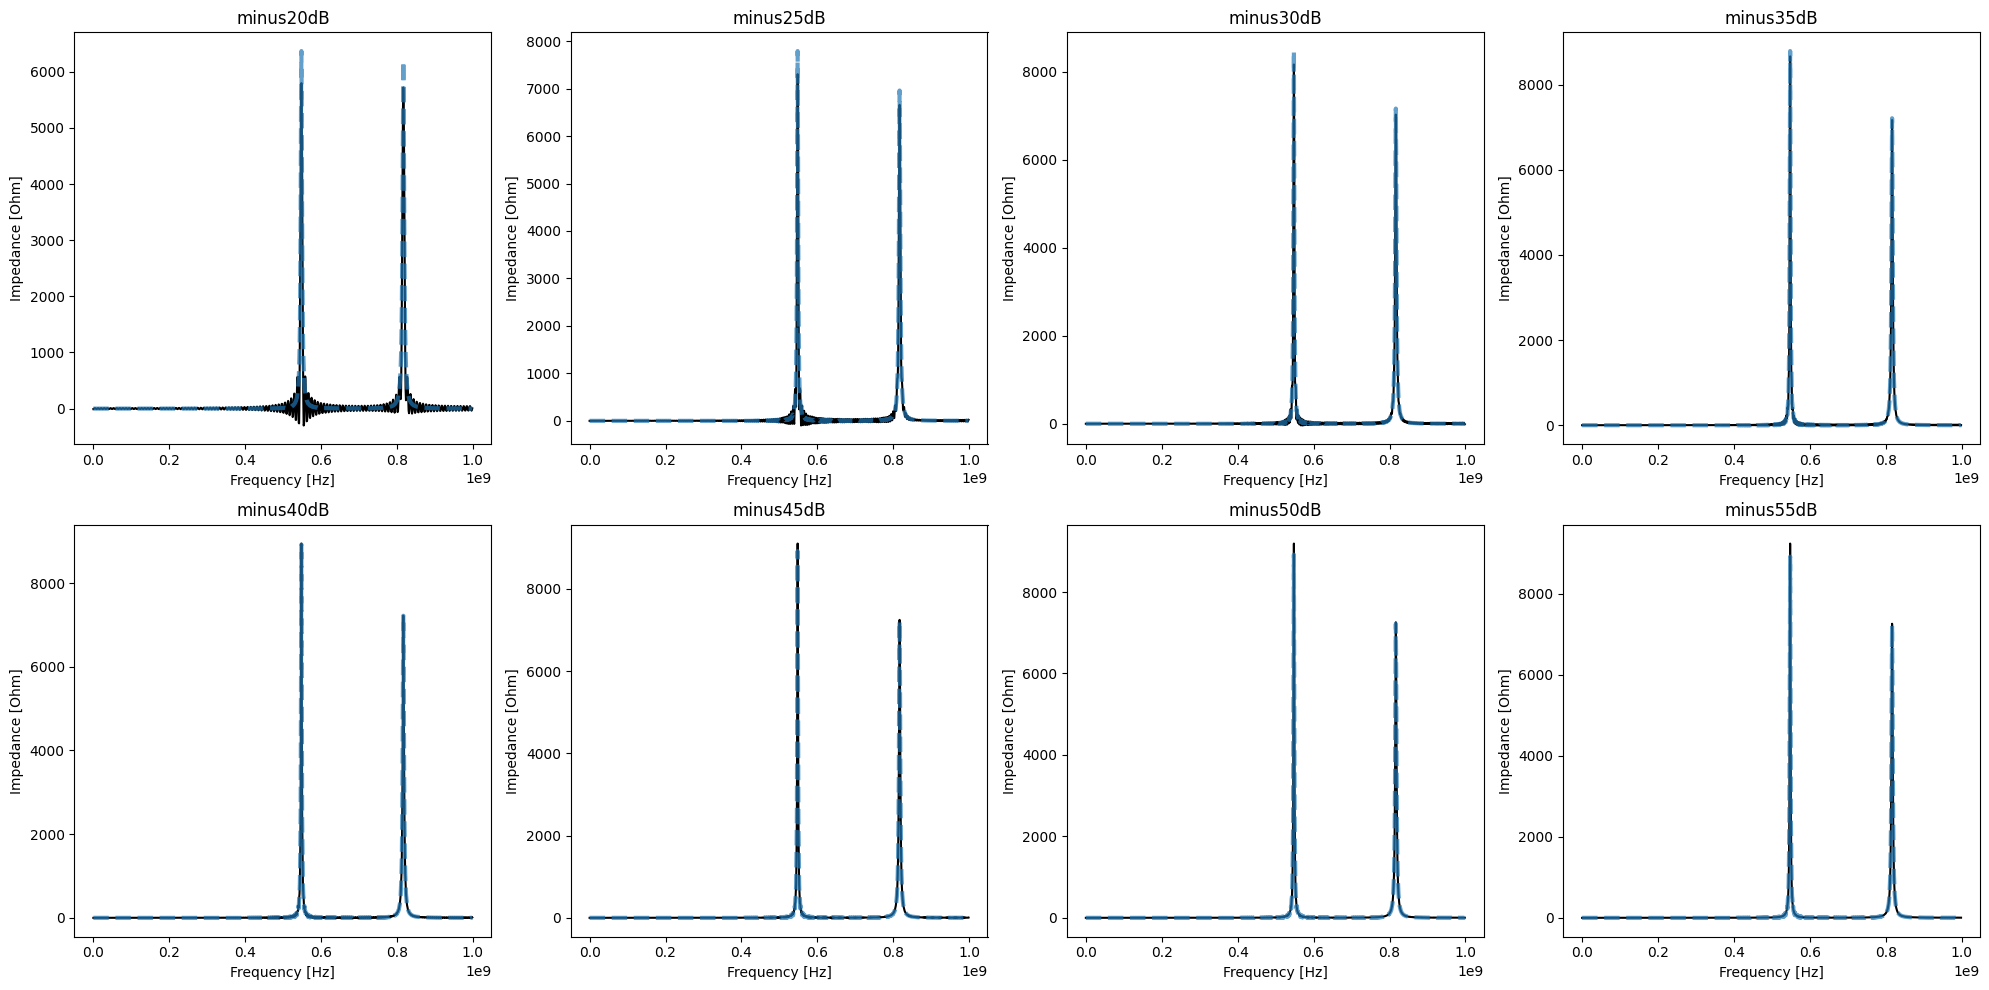

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        
        axes[row, col].plot(results[key].frequency_data, results[key].impedance_data, "black", label='CST data')
        axes[row, col].plot(results[key].frequency_data, results[key].fitFunction(results[key].frequency_data, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
fig.tight_layout()
plt.show()


In [ ]:
# Extrapolating the wake until 210m wakelength

end_time = 210/c_light # Converting from wake length to time. 

"""The time of 210m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(results["minus20dB"].time_data[0], end_time, int(np.round(len(results["minus20dB"].time_data)*(end_time/(results["minus20dB"].time_data[-1])))))

In [ ]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolations = {}

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
        wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
        wake_extrapolations[key] = wake_extrapolated

In [42]:
# Computing the impedance of the fully decayed simulated data:

#instantiating a class. An instance of the WakeSolver class.
wake_fully_simulated = WakeSolver(q = 1e-9, sigmaz = 0.1)

wake_fully_simulated.WP = data_wake[:,1]

wake_fully_simulated.s = data_wake[:,0]/100

#wake_fully_simulated.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

wake_fully_simulated.calc_lambdas_analytic()

wake_fully_simulated.calc_long_Z(samples=1001)

peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

Calculating longitudinal impedance Z...


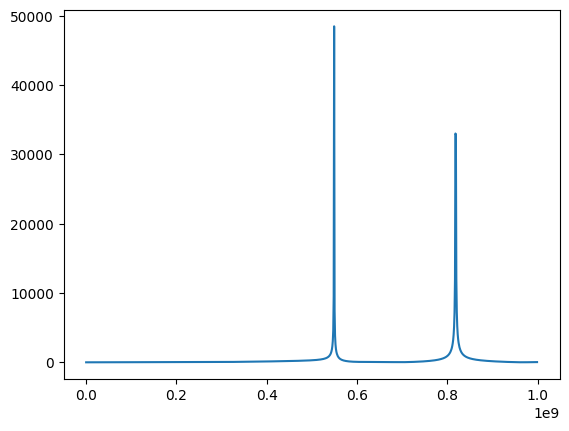

In [43]:
plt.plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z))

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


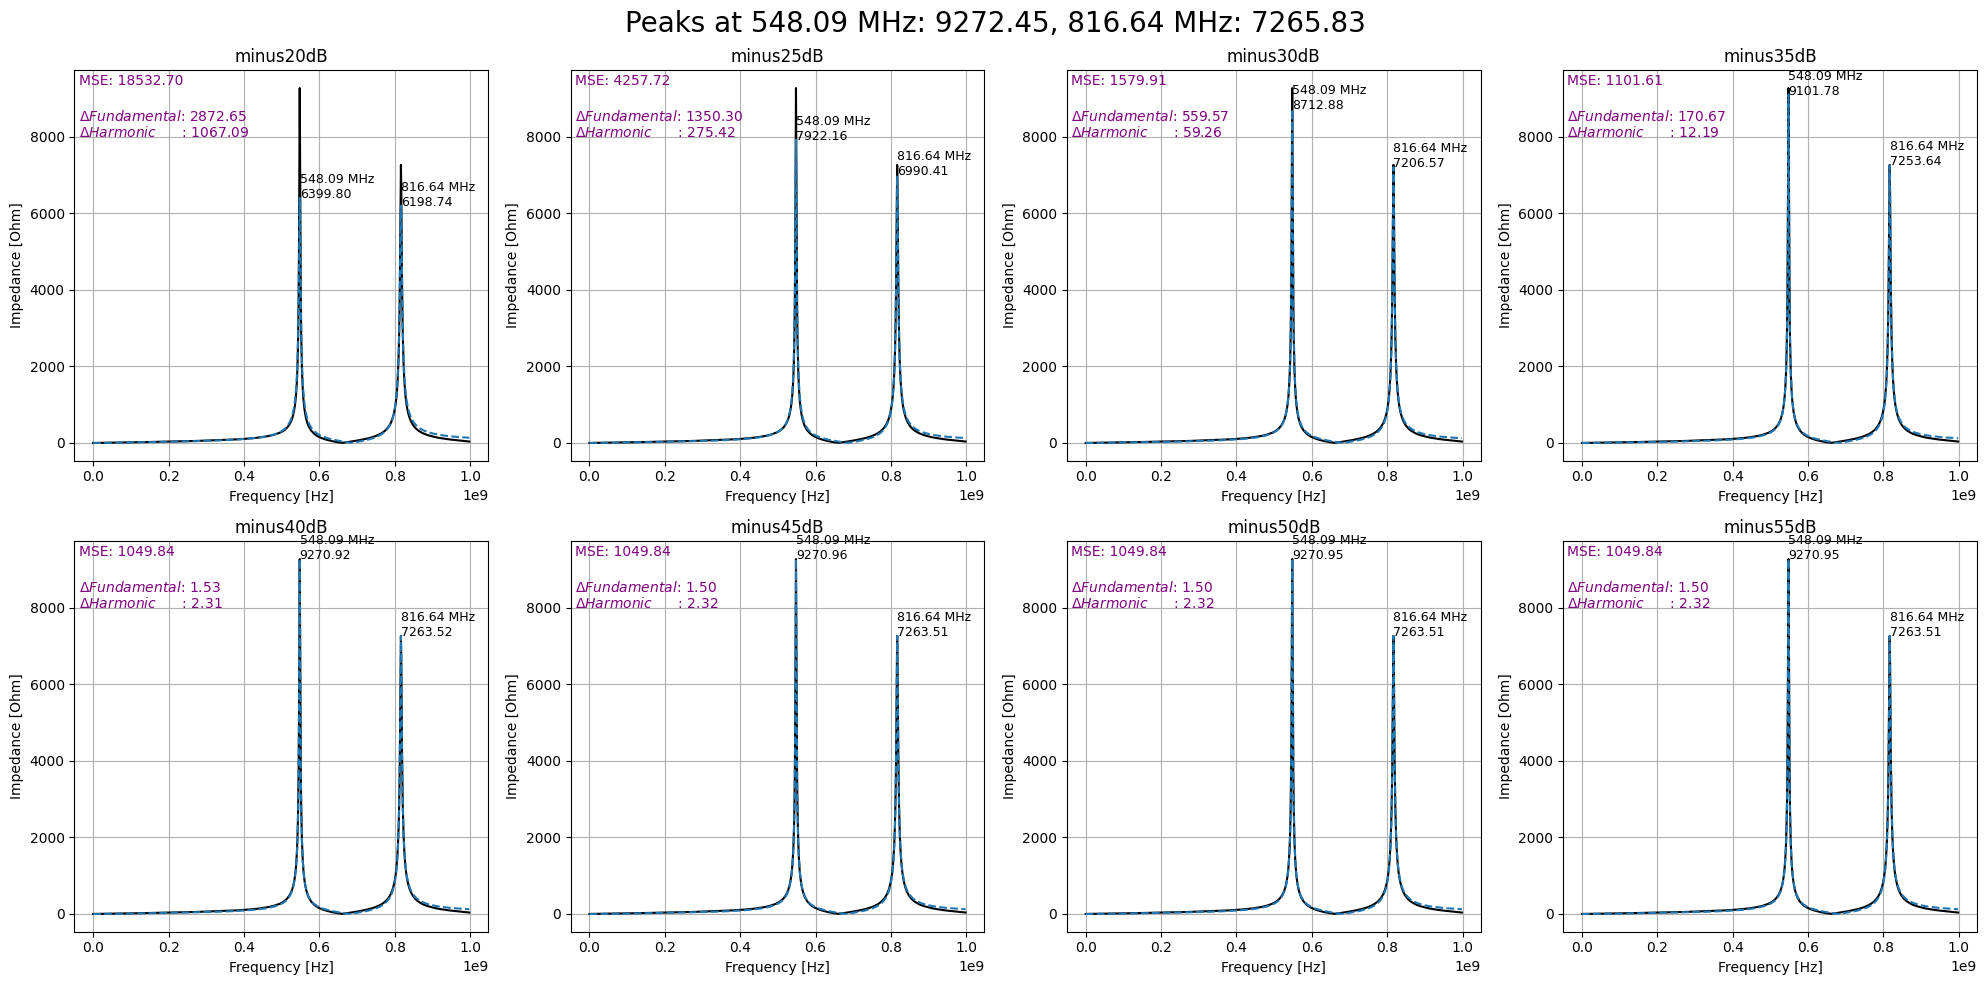

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
peak_info = ', '.join([f'{wake.f[peak]/1e6:.2f} MHz: {height:.2f}' for peak, height in zip(peaks_fs, peaks_height_fs['peak_heights'])])
st = fig.suptitle(f'Peaks at {peak_info}', fontsize=20)

impedance_results = {}

for idx, (key, value) in enumerate(wake_extrapolations.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        #instantiating a class. An instance of the WakeSolver class.
        wake = WakeSolver(q = 1e-9, sigmaz = 0.1)

        #setting the wake potential and time data

        wake.WP = value[:, 1]

        wake.s = new_time_extrapolate*c_light

        wake.lambdas = np.interp(data_wake[:, 0], charge_dist[:, 0], charge_dist[:, 1] / 1e-9 *1e3)

        # Computing the impedance using the WakeSolver class and plotting the result

        wake.calc_long_Z(samples = 1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=2e3, threshold=None)
        
        axes[row, col].plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z), color='black')
        axes[row, col].plot(wake.f, np.abs(wake.Z), linestyle='--')
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e6:.2f} MHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        mse = np.mean((np.abs(wake_fully_simulated.Z) - np.abs(wake.Z))**2)
        axes[row, col].text(.01, .99, f'MSE: {mse:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .90, f'$\Delta Fundamental$: {peaks_height_fs["peak_heights"][0] - peaks_height["peak_heights"][0]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)
        axes[row, col].text(.01, .86, f'$\Delta Harmonic$      : {peaks_height_fs["peak_heights"][1] - peaks_height["peak_heights"][1]:.2f}', horizontalalignment='left', verticalalignment='top', color='purple', transform=axes[row, col].transAxes)


fig.tight_layout()
plt.show()


### 1e6 CONDUCTIVITY

In [44]:
# Importing wake data
data_wake = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e6p.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

# importing energy data to determine attenuation

data_energy = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/-60dB/cond_1e6energy.txt', comments='#', delimiter='\t')

Computing impedance at certain attenuation -x dB

Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...
Calculating longitudinal impedance Z...


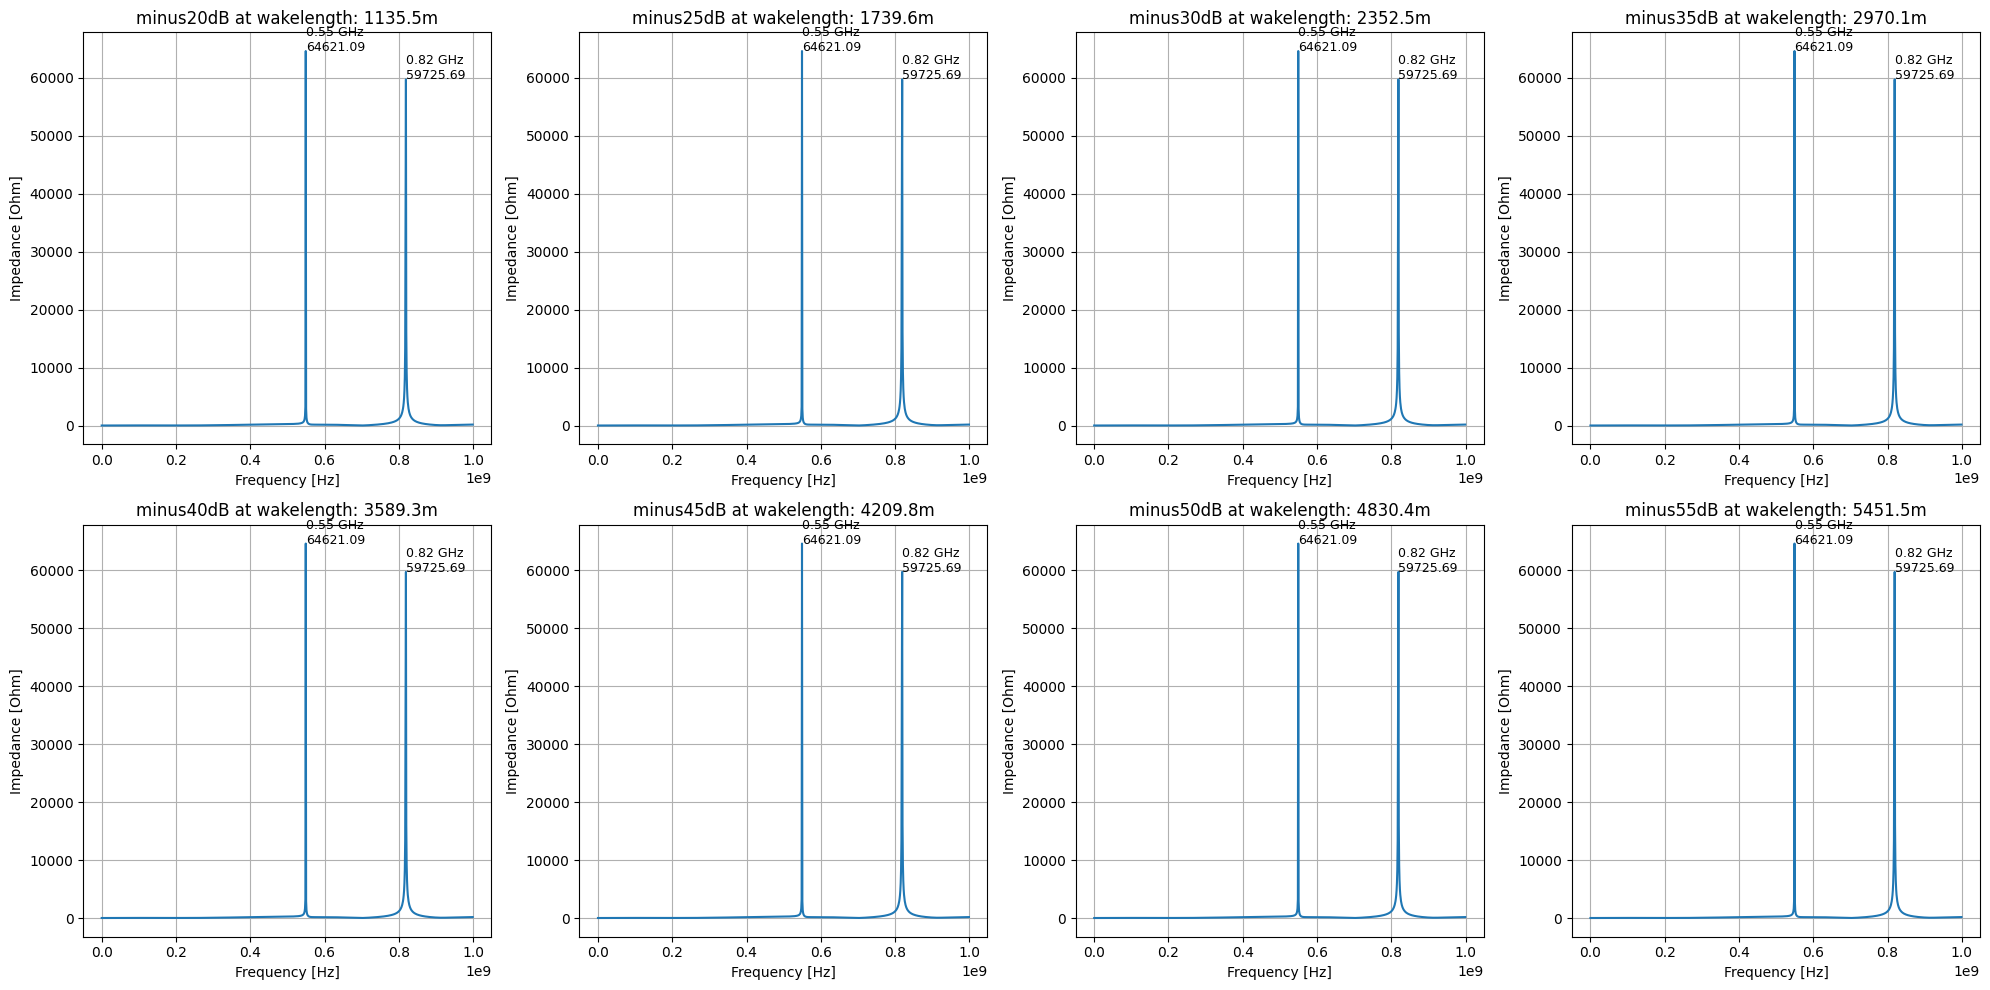

In [45]:
attenuations = [-20.0, -25.0, -30.0, -35.0, -40.0, -45.0, -50.0, -55.0]
row_indices = {}

for attenuation in attenuations:
    row_indices[f'minus{int(abs(attenuation))}dB'] = x_attenuation_data(data_wake, data_energy, attenuation)

impedances_attenuations = row_indices.copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(row_indices.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        wake = WakeSolver(q=1e-9, sigmaz=0.1)
        wake.WP = data_wake[:value, 1]
        wake.s = data_wake[:value, 0] / 100  # Converting from cm to m
        wake.calc_lambdas_analytic()
        wake.calc_long_Z(samples=1001)
        peaks, peaks_height = find_peaks(np.abs(wake.Z), height=5e3, threshold=None)
        
        axes[row, col].plot(wake.f, np.abs(wake.Z))
        axes[row, col].set_title(f'{key} at wakelength: {data_wake[value, 0]/100:.1f}m')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
        for peak, height in zip(peaks, peaks_height['peak_heights']):
            axes[row, col].text(wake.f[peak], np.abs(wake.Z)[peak], f'{wake.f[peak]/1e9:.2f} GHz\n{height:.2f}', fontsize=9)
        axes[row, col].grid(True)

        impedances_attenuations.update({key: wake.Z})


fig.tight_layout()
plt.show()


In [ ]:
frequency = wake.f # Frequency in Hz

Nres = 2

bounds = [(10e3, 35e3), (1, 1e3), (0.3e9, 0.9e9)] # Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [ ]:
%%time
results = {}
for key, impedance in impedances_attenuations.items():
    GA_model_scipy = GeneticAlgorithm(frequency, 
                                      impedance, 
                                      time, 
                                      wake, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                     )
    GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                        popsize=150, 
                                        tol=0.001, 
                                        mutation=(0.1, 0.5), 
                                        crossover_rate=0.8
                                       )
    results[key] = GA_model_scipy
print(GA_model_scipy.warning)

Progress: [######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.14e+04        |      576.29      |    8.181e+08     
    2     |        2.52e+04        |      559.52      |    5.489e+08     
----------------------------------------------------------------------
Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.27e+04        |      628.82      |    8.181e+08     
    2     |        2.93e+04        |      684.79      |    5.489e+08     
----------------------------------------------------------------------
Progress: [#########################] 100% 

In [ ]:
for key, value in results.items():
    results[key].run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.14e+04        |      576.88      |    8.181e+08     
    2     |        2.52e+04        |      561.40      |    5.489e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.28e+04        |      629.36      |    8.181e+08     
    2     |        2.91e+04        |      678.48      |    5.489e+08     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


------------------------------------------------

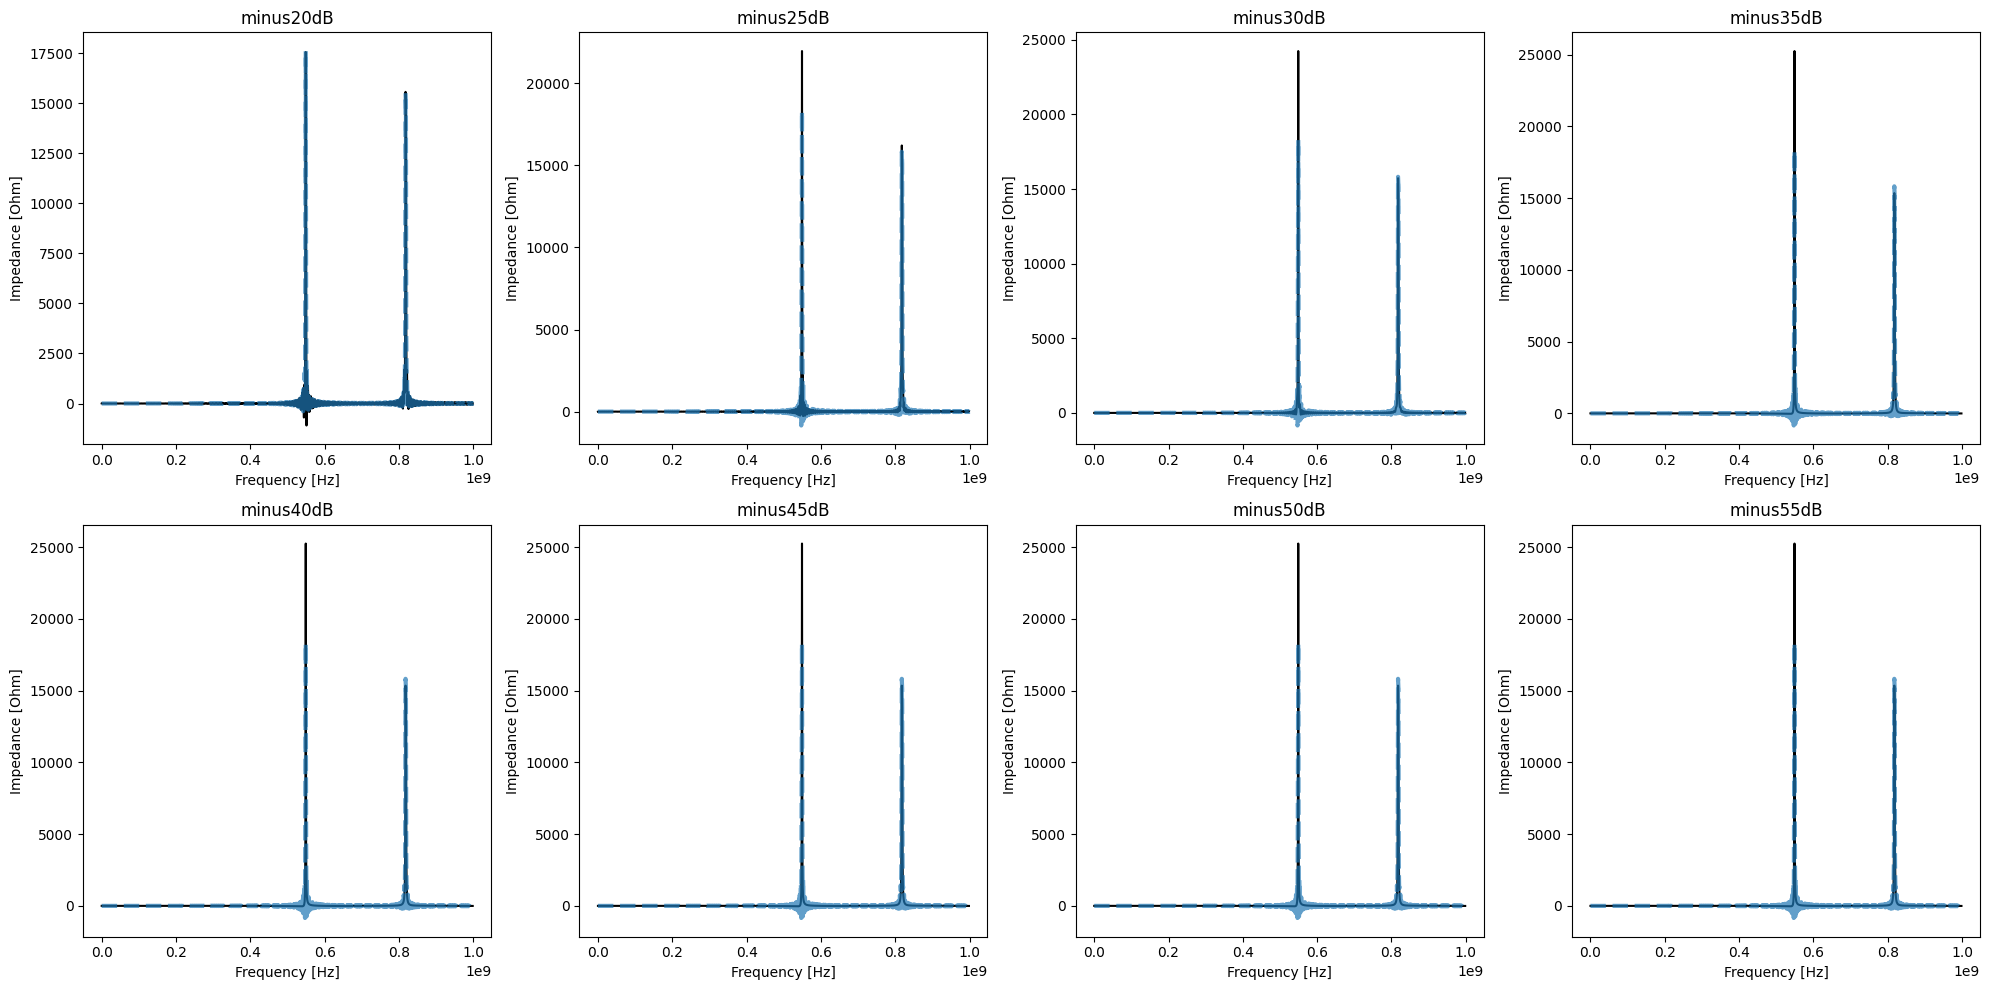

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        row = idx // 4
        col = idx % 4
        
        axes[row, col].plot(results[key].frequency_data, results[key].impedance_data, "black", label='CST data')
        axes[row, col].plot(results[key].frequency_data, results[key].fitFunction(results[key].frequency_data, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)
        axes[row, col].set_title(f'{key}')
        axes[row, col].set_xlabel('Frequency [Hz]')
        axes[row, col].set_ylabel('Impedance [Ohm]')
fig.tight_layout()
plt.show()


In [ ]:
# Extrapolating the wake until 625m wakelength

end_time = 650/c_light # Converting from wake length to time. 

"""The time of 625m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(results["minus20dB"].time_data[0], end_time, int(np.round(len(results["minus20dB"].time_data)*(end_time/(results["minus20dB"].time_data[-1])))))

In [ ]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolations = {}

for idx, (key, value) in enumerate(results.items()):
    if key != 'key':  # Skip the 'key' entry
        wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(results[key].minimizationParameters.reshape(-1, 3))))*1e-13
        wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))
        wake_extrapolations[key] = wake_extrapolated

In [46]:
# Computing the impedance of the fully decayed simulated data:

#instantiating a class. An instance of the WakeSolver class.
wake_fully_simulated = WakeSolver(q = 1e-9, sigmaz = 0.1)

wake_fully_simulated.WP = data_wake[:,1]

wake_fully_simulated.s = data_wake[:,0]/100

wake_fully_simulated.calc_lambdas_analytic()

wake_fully_simulated.calc_long_Z(samples=1001)

peaks_fs, peaks_height_fs = find_peaks(np.abs(wake_fully_simulated.Z), height=2e3, threshold=None)

Calculating longitudinal impedance Z...


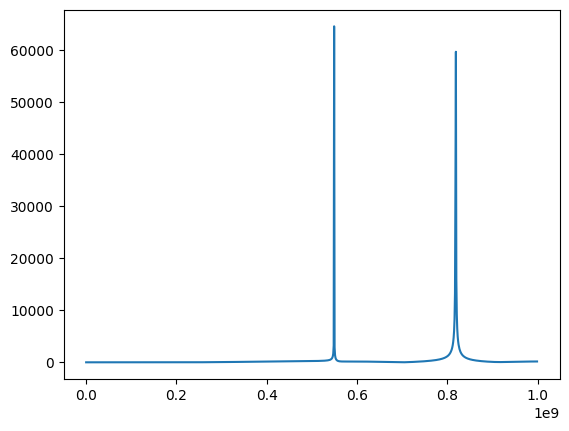

In [47]:
plt.plot(wake_fully_simulated.f, np.abs(wake_fully_simulated.Z))